# 0.Introduction

## 0.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pandas import DataFrame
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.svm import SVR
import datetime
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from IPython.display import display_html 
from re import VERBOSE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from pyparsing.helpers import disable_diag
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore", category= RuntimeWarning)
warnings.filterwarnings("ignore", category= FutureWarning)
set_config(display="diagram")

## 0.2 Variables

In [ ]:
#dataframe to save various results
results_mse = pd.DataFrame(columns=['modelName', 'train_mse', 'test_mse', 'difference'])
results_mae = pd.DataFrame(columns=['modelName', 'train_mae', 'test_mae', 'difference'])
results_r2score = pd.DataFrame(columns=['modelName', 'train_r2score', 'test_r2score', 'difference'])
results_evs = pd.DataFrame(columns=['modelName', 'train_evs', 'test_evs', 'difference'])

## 0.3 Functions

### -data preparation

In [ ]:
#checks missing data in %-tage in given dataset
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#show boxplot for dataset befroe modifications and after
def boxplot_compare_dist(df, y_before, y_after):
    f = plt.figure(figsize=(16,8))
    st = f.suptitle(f"{y_before} comparison", fontsize="x-large")
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(df[y_before])
    plt.subplot(2,2,3)
    sns.boxplot(y=y_before, data = df)
    ax2=plt.subplot(2,2,2)
    b = sns.distplot(df [y_after])
    plt.subplot(2,2,4)
    sns.boxplot(y=y_after, data = df)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#transform specific column with requested tranfromer
def transform (transf, X_train, X_test, name, col):
  #train
  X_train_df = pd.DataFrame(X_train, columns = ['AT','V', 'AP', "RH"])
  X_train_df = X_train_df.drop(['AT','V'], axis=1)
  data_trans = transf.fit_transform(X_train_df) 
  data_trans_df = pd.DataFrame(data_trans, columns = ['AP', "RH"])

  #test
  X_test_df = pd.DataFrame(X_test, columns = ['AT','V', 'AP', "RH"])
  X_test_df = X_test_df.drop(['AT','V'], axis=1)
  data_trans_test = transf.transform(X_test_df)
  data_trans_test_df = pd.DataFrame(data_trans_test, columns = ['AP', "RH"])

  #show results
  compare_to_normal (X_train_df,data_trans_df, col, f'{name}_Train')
  compare_to_normal (X_test_df,data_trans_test_df, col, f'{name}_Test')
  return data_trans, data_trans_test

In [ ]:
#iterate over list of transformers and check specific column
def transform_list(X_train, X_test, col):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform(transformer_list[j] ,X_train, X_test, transformer_names[j], col) 

In [ ]:
def transform_y (y_train,y_test):
  y_target = y_train.to_numpy()
  y_tr_test = y_test.to_numpy()

  y_data = y_target.reshape(len(y_target), 1)
  y_data_test = y_tr_test.reshape(len(y_tr_test), 1)

  # QuantileTransformer to make bimodel to uniform
  quant_trans = QuantileTransformer(n_quantiles=300, output_distribution='uniform')

  y_trans = quant_trans.fit_transform(y_data)
  y_trans_test = quant_trans.transform(y_data_test)
  return y_target, y_trans,  y_tr_test, y_trans_test

In [ ]:
#plot specific column before modification and after modification in comparison to normal destribution
def compare_to_normal (df_before,df_after, col, name):
    f = plt.figure(figsize = (50, 10))
    st = f.suptitle(f"{col}_{name}", fontsize=30)
    plt.subplot(1, 4, 1)
    data = df_before[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 2)
    stats.probplot(df_before[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 3)
    data = df_after[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.subplot(1, 4, 4)
    stats.probplot(df_after[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.show()

In [ ]:
#split and impute dataset
def reset_t_t_split(df, imputer):
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  #impute
  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)
  return X_train_i, X_test_i, y_train, y_test

In [ ]:
# scale only
def scale (scaler, X_train_i, X_test_i, y_train, y_test ):
  #scale
  sc_x=scaler
  sc_y=scaler
  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  X_train_sc = sc_x.fit_transform(X_train_i)
  X_test_sc = sc_x.transform(X_test_i)
  y_train_sc = sc_y.fit_transform(y_train_r)
  y_test_sc = sc_y.transform(y_test_r)
  
  return  X_train_sc, X_test_sc, y_train_sc, y_test_sc, sc_y, y_test, y_train

In [ ]:
def transform_scale_RH (RH_transformer, df, scaler):
  X_train_o, X_test_o, y_train, y_test = reset_t_t_split(df, KNNImputer(n_neighbors=2))
  #train and test numpy array with transfromed RH col
 
  RH_train, RH_test = transform(RH_transformer,X_train_o, X_test_o, 'final_transform_box_cox', 'RH')

  RH_train_col = RH_train[:,[1]]
  X_train_mod = X_train_o[:,[0,1,2]]
  X_train_final_RH = np.append(X_train_mod, RH_train_col, axis=1)


  RH_test_col = RH_test[:,[1]]
  X_test_mod = X_test_o[:,[0,1,2]]
  X_test_final_RH = np.append(X_test_mod, RH_test_col, axis=1)

  X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig = scale(scaler, X_train_final_RH, X_test_final_RH , y_train, y_test)
  return X_train, X_test, y_train, y_test, sc_y, y_test_orig, y_train_orig

### -model training

In [ ]:
#split dataset and preprocess data according to given pipeline
def split_impute_scale_pipe (df, pipe, imputer, winsorize_rh = False,winsorize_ap = False):
  pipe_s = define_pipeline_simple(RobustScaler())
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  y_test_orig, y_train_orig = y_test, y_train

  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)

  cols = ['AT', 'V', 'AP', 'RH']
  if winsorize_rh:
    X_train_i = winsorize_nparray(X_train_i, 3,  0.00135, 0)
    X_test_i = winsorize_nparray(X_test_i, 3,  0.00135, 0)
    
  if winsorize_ap:
    X_train_i= winsorize_nparray(X_train_i, 2,  0.00165, 0.015)
    X_test_i= winsorize_nparray(X_test_i, 2,  0.00165, 0.015)
    cols = ['AT', 'V', 'RH', 'AP']

  X_train_i = pd.DataFrame(X_train_i, columns = cols)
  X_test_i = pd.DataFrame(X_test_i, columns = cols)

  X_train_p = pipe.fit_transform(X_train_i)
  X_test_p = pipe.transform(X_test_i)

  pipe 

  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  y_train_p = pipe_s.fit_transform(y_train_r)
  y_test_p = pipe_s.transform(y_test_r)

  return X_train_p, X_test_p, y_train_p, y_test_p, pipe_s,  y_test_orig, y_train_orig

In [ ]:
#define pipeline with scaler only
def define_pipeline_simple(scaler):
  pipe_simple = Pipeline([
    ('scaler', scaler)
    ])
  return pipe_simple

In [ ]:
#define pipeline with transformer and scaler:

def define_pipeline_complex(scaler, rh_step, ap_step, is_rh = True, is_ap = True ):
  if is_rh:
    rh_pipe = Pipeline([('transformer_step', rh_step),
                        ('scaler', scaler)])
  else:
    rh_pipe = Pipeline([('scaler', scaler)])
  
  if is_ap:
    ap_pipe = Pipeline([('preprocess_step', ap_step),
                        ('scaler', scaler)])
  else:
    ap_pipe =  Pipeline([('scaler', scaler)])

  simple_pipe = define_pipeline_simple(RobustScaler())                        
  pipe = ColumnTransformer(
    [("RH_col"  , rh_pipe  , ["RH"]),
     ("AP_col", ap_pipe, ["AP"])
    ],
    remainder = simple_pipe
  )
  set_config(display="diagram")

  return pipe

In [ ]:
def winsorize_nparray(nparray, col_index, lower, upper):
  array_col =  nparray[ : , col_index]
  array_col_win = winsorize(array_col, (lower, upper))
  array_col_win_reshape = array_col_win.reshape(len(array_col_win), 1)
  combo = np.delete(nparray, col_index, 1)
  nparray = np.c_[combo, array_col_win_reshape]
  return nparray

#### -ML model training

In [ ]:
#train ML model, evaluate, save to results dataframe
def train_report_hist_pipe (name,regressor, pipe):
    model = regressor
    model.fit(X_train, y_train)
    results = pd.DataFrame(columns=['modelName', 'mse', 'mae',  'evs', 'r2'])


    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination: {r_sq}")
#train
    y_pred_train = pipe.inverse_transform(model.predict(X_train).reshape(-1,1))

    r2_score_train =  r2_score(y_train_orig, y_pred_train)
    evs_train = explained_variance_score(y_train_orig, y_pred_train)
    mae_train =  mean_absolute_error(y_train_orig, y_pred_train)
    mse_train = mean_squared_error(y_train_orig, y_pred_train)
#test
    y_pred_test = pipe.inverse_transform(model.predict(X_test).reshape(-1,1))
  
    r2_score_test =  r2_score(y_test_orig, y_pred_test)
    evs_test = explained_variance_score(y_test_orig, y_pred_test)
    mae_test =  mean_absolute_error(y_test_orig, y_pred_test)
    mse_test = mean_squared_error(y_test_orig, y_pred_test)
#difference
    diff_r2 = r2_score_train - r2_score_test
    diff_evs = evs_train - evs_test
    diff_mae = mae_test - mae_train
    diff_mse = mse_test - mse_train

    results_r2score.loc[len(results_r2score.index)] = [name, round( r2_score_train*100,3), round( r2_score_test*100,3), round( diff_r2*100,3)]
    results_evs.loc[len(results_evs.index)] = [name, round( evs_train*100,3), round( evs_test*100,3), round( diff_evs*100,3)]
    results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
    results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

    results.loc[len(results.index)] = [f'{name}_train', round( mse_train,3), round( mae_train,3),round( evs_train*100,3),round( r2_score_train*100,3) ]
    results.loc[len(results.index)] = [f'{name}_test', round( mse_test,3), round( mae_test,3),round( evs_test*100,3),round( r2_score_test*100,3) ]

    print (results)

#### -ANN model training

In [ ]:
#define model architecture and complie model
def define_model (name, opt, n_layers, unt, input_vec_len):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units = unt, activation = 'relu', input_shape = (input_vec_len,)))
  for n in range(1, n_layers):
     model.add(tf.keras.layers.Dense(units = unt, activation = 'relu'))
  model.add(tf.keras.layers.Dense(units = 1))
  model.compile(optimizer = opt, loss="mse",  metrics = ['mae'])
  return model

In [ ]:
#evaluate model
def evaluate_model_pipe (name, pipe, pat,  n_layers, unt, batch, opt, ep,  n_folds = 5):
  histories = list()
  early_stopping_monitor = EarlyStopping(patience=pat)
  checkpointer = ModelCheckpoint(
      filepath = f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_{name}.hdf5',
      verbose = 1,
      save_best_only = True
  )
  input_vec_len = X_train.shape[1]
  name = define_model(name, opt, n_layers, unt, input_vec_len)
  history = name.fit(X_train, y_train, epochs = ep, batch_size = batch, verbose = 0, validation_data=(X_test, y_test), callbacks= [early_stopping_monitor, checkpointer])
  histories.append(history)
  _y_pred_test = name.predict(X_test).reshape(-1,1)
  y_pred_test = pipe.inverse_transform(_y_pred_test)
  y_pred_train = pipe.inverse_transform(name.predict(X_train).reshape(-1,1))
  return histories, y_pred_test, y_pred_train

In [ ]:
#plot diagnostic learning curves
def show_plots (histories, name):
  f = plt.figure(figsize=(30,4))
  st = f.suptitle(name, fontsize="x-large")

  plt.subplot(1,2,1)
  # plot loss during training
  plt.title('Loss (Mean Squared Error)')
  plt.plot(histories[0].history['loss'], label='train mse')
  plt.plot(histories[0].history['val_loss'], label='test mse')
  ax = plt.gca()
  ax.get_yaxis().set_visible(False)
  plt.legend()

  plt.subplot (1,2,2)
  plt.title('Mean Absolute Error')
  plt.plot(histories[0].history['mae'], label='train mae')
  plt.plot(histories[0].history['val_mae'], label='test mae')
  axes = plt.gca()
  axes.get_yaxis().set_visible(False)
  plt.legend()

  plt.savefig(f"{name} model results.pdf") 
  plt.show()

In [ ]:
#count results and save to dataframe
def results(name,  y_pred_test,  y_pred_train):
  r2_score_train = round(r2_score(y_train_orig, y_pred_train)*100,3)
  evs_train = round(explained_variance_score(y_train_orig, y_pred_train)*100,3)
  mae_train = mean_absolute_error(y_train_orig, y_pred_train)
  mse_train = mean_squared_error(y_train_orig, y_pred_train)

  r2_score_test = round(r2_score(y_test_orig, y_pred_test)*100,3)
  evs_test = round(explained_variance_score(y_test_orig, y_pred_test)*100,3)
  mae_test = mean_absolute_error(y_test_orig, y_pred_test)
  mse_test = mean_squared_error(y_test_orig, y_pred_test)

  #difference
  diff_r2 = r2_score_train - r2_score_test
  diff_evs = evs_train - evs_test
  diff_mae = mae_test - mae_train
  diff_mse = mse_test - mse_train

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, round(diff_r2,3)]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, round( diff_evs,3)]
  results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3), round( diff_mae,3)]
  results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3), round( diff_mse,3)]

  results = pd.DataFrame(columns = ['type', 'mean_squared_error', 'mean_absolute_error',  'r2_score', 'e_v_score'])
  results.loc[0] = [f"train:_{name}", round( mse_train,3),round( mae_train,3), r2_score_train ,evs_train]
  results.loc[1] = [f"test:_{name}",  round( mse_test,3) , round( mae_test,3) , r2_score_test ,evs_test]
  results.loc[2] = [f"{name}", round( diff_mse,3) , round( diff_mae,3) , round( diff_r2,3) ,round( diff_evs,3)]

  print(results)
  return results

In [ ]:
# complete run from model training, evaluation, vizualization and resalts saving
def complete_run (name, pipe,ep = 450, pat = 50, opt = 'adam', n_layers = 1, unt = 6, batch = 256):

  histories, y_pred_test, y_pred_train = evaluate_model_pipe (name, pipe, pat, n_layers, unt, batch, opt, ep,  n_folds = 5)

  show_plots(histories, name)
  
  data_res = results(name,  y_pred_test,  y_pred_train)
  data_res.to_csv(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results/{name}_results.csv', index=False) 

In [ ]:
#upload results from path and save to main results df
def upload_save_results(df):
  name = df.loc[2]['type']
  r2_score_train = df.loc[0]['r2_score']
  evs_train = df.loc[0]['e_v_score']
  mae_train = df.loc[0]['mean_absolute_error']
  mse_train = df.loc[0]['mean_squared_error']

  r2_score_test = df.loc[1]['r2_score']
  evs_test = df.loc[1]['e_v_score']
  mae_test = df.loc[1]['mean_absolute_error']
  mse_test = df.loc[1]['mean_squared_error']

    #difference
  diff_r2 = df.loc[2]['r2_score']
  diff_evs = df.loc[2]['e_v_score']
  diff_mae = df.loc[2]['mean_absolute_error']
  diff_mse = df.loc[2]['mean_squared_error']

  results_r2score.loc[len(results_r2score.index)] = [name, r2_score_train, r2_score_test, diff_r2]
  results_evs.loc[len(results_evs.index)] = [name, evs_train, evs_test, diff_evs]
  results_mae.loc[len(results_mae.index)] = [name, mae_train, mae_test, diff_mae]
  results_mse.loc[len(results_mse.index)] = [name, mse_train, mse_test, diff_mse]

In [ ]:
#update results from saved files
def update_results(isFinal = False):
  mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results'
  if isFinal:
    mypath = '/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/results_final'
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  for file in onlyfiles:
    df = pd.read_csv(f"{mypath}/{file}")
    upload_save_results(df)

In [ ]:
#save model as json file
def save_model_as_json(model,name):
  model_json = model.to_json()
  with open(f'/content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-classifier-model_{name}.json', 'w') as json_file:
    json_file.write(model_json)

### -show results

In [ ]:
def percent_graph (df, test):
  N = len(df.iloc[:10])
  new_df = df.sort_values(test, ascending=True).iloc[:10]
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[test].values.tolist(), color = 'orange')
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[test].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
      ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'white', fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def failure_graph (df, train, test):
  N = len(df)
  new_df = df.sort_values(test, ascending=False)
  ind = np.arange(N) 
  name = new_df['modelName'].head(12)
  # Figure Size
  fig, ax = plt.subplots(figsize =(20, 7))
  ax.barh(name, new_df[train].values.tolist())
  ax.barh(name, new_df['difference'].values.tolist(), left = new_df[train].values.tolist())
  for bar, disease in zip(ax.patches,new_df[test].values.tolist()):
    ax.text(0.3, bar.get_y()+bar.get_height()/2, disease, color = 'orange',fontsize=15, ha = 'left', va = 'center') 
  plt.show()

In [ ]:
def show_results(isGraph = True):
    new_results_mse = results_mse.sort_values('test_mse', ascending=True)
    new_results_mae = results_mae.sort_values('test_mae', ascending=True)
    new_results_r2score = results_r2score.sort_values('test_r2score', ascending=False)
    new_results_evs = results_evs.sort_values('test_evs', ascending=False)

    df1_styler = new_results_mse.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MSE')
    df2_styler = new_results_mae.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MAE')
    df3_styler = new_results_r2score.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('r2score')
    df4_styler = new_results_evs.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('EVS')
    
    display_html(df1_styler._repr_html_()+"____\n"+df2_styler._repr_html_()+"____"+df3_styler._repr_html_()+"____"+df4_styler._repr_html_(), raw=True)

    m_mse = new_results_mse['modelName'].to_list()
    tr_mse = new_results_mse['train_mse'].to_list()
    te_mse = new_results_mse['test_mse'].to_list()

    m_mae = new_results_mae['modelName'].to_list()
    tr_mae = new_results_mae['train_mae'].to_list()
    te_mae = new_results_mae['test_mae'].to_list()

    m_r2score = new_results_r2score['modelName'].to_list()
    tr_r2score = new_results_r2score['train_r2score'].to_list()
    te_r2score = new_results_r2score['test_r2score'].to_list()

    m_evs = new_results_evs['modelName'].to_list()
    tr_evs = new_results_evs['train_evs'].to_list()
    te_evs = new_results_evs['test_evs'].to_list()

    f = plt.figure(figsize=(40,15))
    st = f.suptitle('Results', fontsize="x-large")

    if isGraph:
      failure_graph(results_mse, 'train_mse', 'test_mse')
      failure_graph(results_mae, 'train_mae', 'test_mae')
      percent_graph (results_evs, 'test_evs')
      percent_graph (results_r2score, 'test_r2score')
    
    

# 3.ANN model tuning

## 3.1 Modifying model architecture in combination with optimizers

### Adadelta


Epoch 1: val_loss improved from inf to 0.37012, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_6.hdf5

Epoch 2: val_loss improved from 0.37012 to 0.37004, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_6.hdf5

Epoch 3: val_loss improved from 0.37004 to 0.36996, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_6.hdf5

Epoch 4: val_loss improved from 0.36996 to 0.36988, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_6.hdf5

Epoch 5: val_loss improved from 0.36988 to 0.36980, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimiz

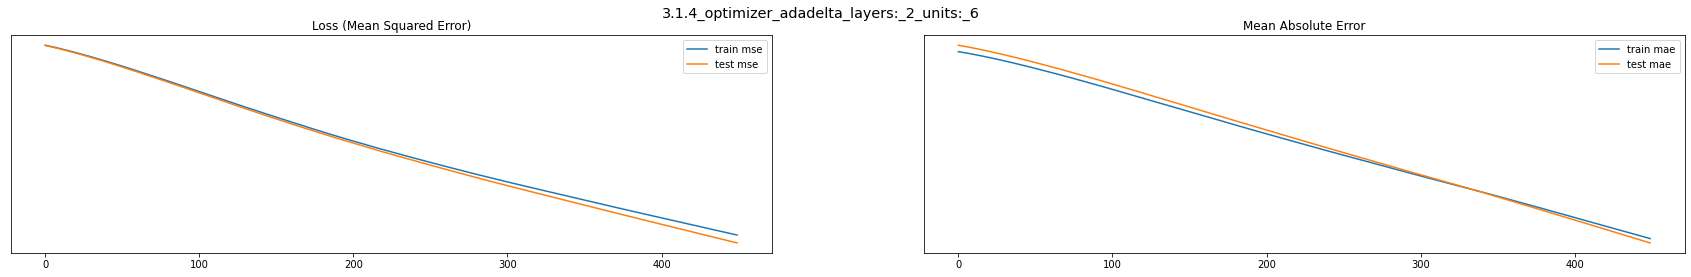

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_2_unit...             262.440   
1  test:_3.1.4_optimizer_adadelta_layers:_2_units:_6             261.009   
2        3.1.4_optimizer_adadelta_layers:_2_units:_6              -1.431   

   mean_absolute_error  r2_score  e_v_score  
0               13.368     9.637     16.055  
1               13.347    10.967     16.773  
2               -0.021    -1.330     -0.718  

Epoch 1: val_loss improved from inf to 0.57953, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_8.hdf5

Epoch 2: val_loss improved from 0.57953 to 0.57903, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_8.hdf5

Epoch 3: val_loss improved from 0.57903 to 0.57850, saving model to /content/drive/MyDrive/Colab N

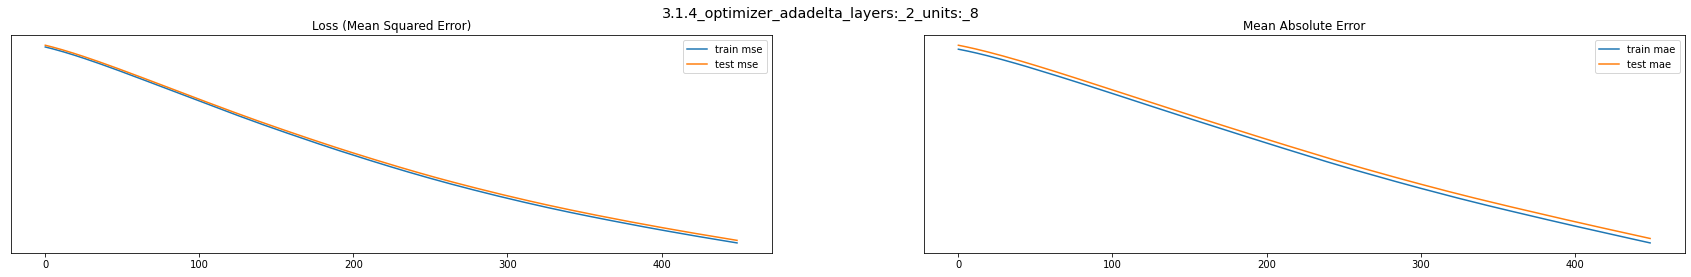

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_2_unit...             249.028   
1  test:_3.1.4_optimizer_adadelta_layers:_2_units:_8             251.974   
2        3.1.4_optimizer_adadelta_layers:_2_units:_8               2.946   

   mean_absolute_error  r2_score  e_v_score  
0               13.463    14.255     14.316  
1               13.567    14.049     14.075  
2                0.105     0.206      0.241  

Epoch 1: val_loss improved from inf to 0.47867, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_16.hdf5

Epoch 2: val_loss improved from 0.47867 to 0.47786, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_16.hdf5

Epoch 3: val_loss improved from 0.47786 to 0.47703, saving model to /content/drive/MyDrive/Colab

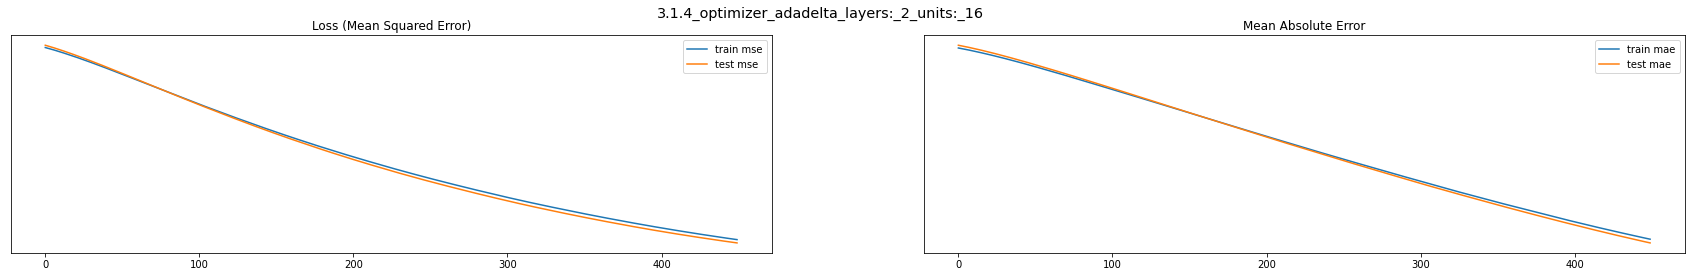

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_2_unit...              96.637   
1  test:_3.1.4_optimizer_adadelta_layers:_2_units...              91.927   
2       3.1.4_optimizer_adadelta_layers:_2_units:_16              -4.710   

   mean_absolute_error  r2_score  e_v_score  
0                7.638    66.726     67.304  
1                7.480    68.643     69.064  
2               -0.159    -1.917     -1.760  

Epoch 1: val_loss improved from inf to 0.39801, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_32.hdf5

Epoch 2: val_loss improved from 0.39801 to 0.39700, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_32.hdf5

Epoch 3: val_loss improved from 0.39700 to 0.39597, saving model to /content/drive/MyDrive/Colab

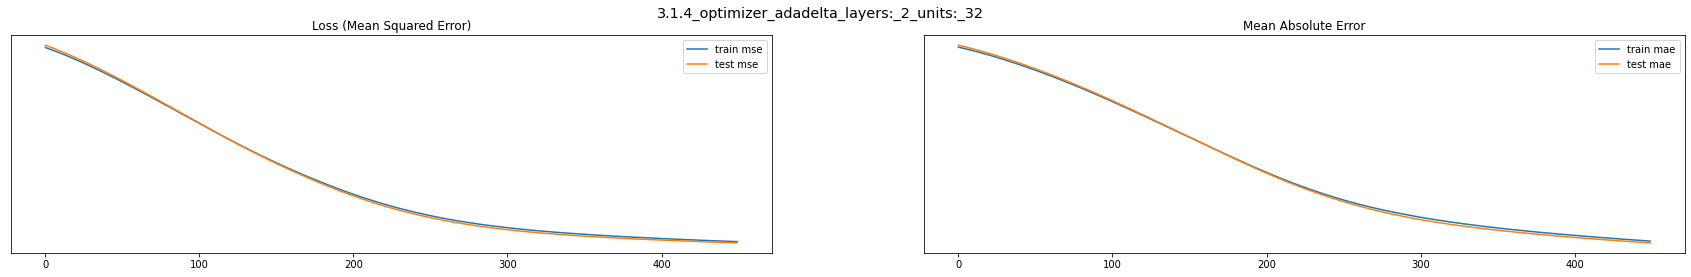

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_2_unit...              33.125   
1  test:_3.1.4_optimizer_adadelta_layers:_2_units...              31.301   
2       3.1.4_optimizer_adadelta_layers:_2_units:_32              -1.824   

   mean_absolute_error  r2_score  e_v_score  
0                4.521    88.595     88.677  
1                4.425    89.323     89.407  
2               -0.097    -0.728     -0.730  

Epoch 1: val_loss improved from inf to 0.33231, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_64.hdf5

Epoch 2: val_loss improved from 0.33231 to 0.33107, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_64.hdf5

Epoch 3: val_loss improved from 0.33107 to 0.32978, saving model to /content/drive/MyDrive/Colab

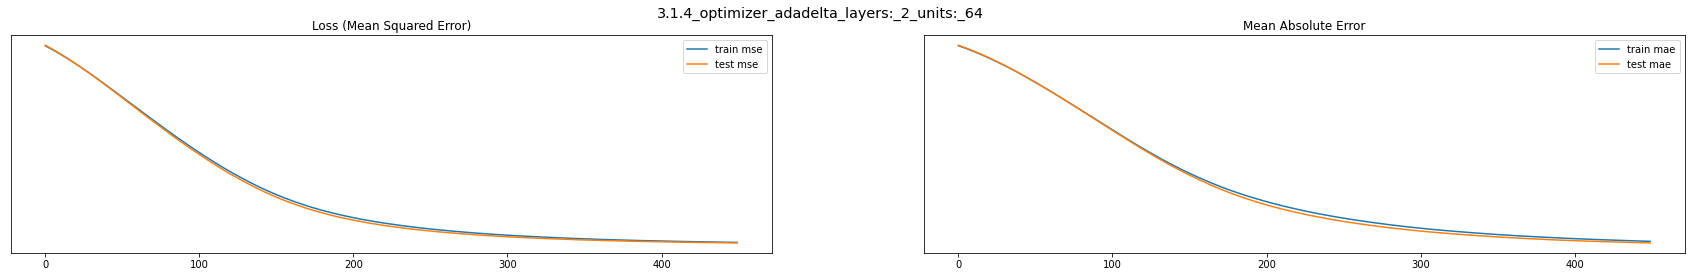

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_2_unit...              23.276   
1  test:_3.1.4_optimizer_adadelta_layers:_2_units...              22.654   
2       3.1.4_optimizer_adadelta_layers:_2_units:_64              -0.622   

   mean_absolute_error  r2_score  e_v_score  
0                3.796    91.986     91.986  
1                3.713    92.273     92.274  
2               -0.083    -0.287     -0.288  

Epoch 1: val_loss improved from inf to 0.32658, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_128.hdf5

Epoch 2: val_loss improved from 0.32658 to 0.32436, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_2_units:_128.hdf5

Epoch 3: val_loss improved from 0.32436 to 0.32210, saving model to /content/drive/MyDrive/Col

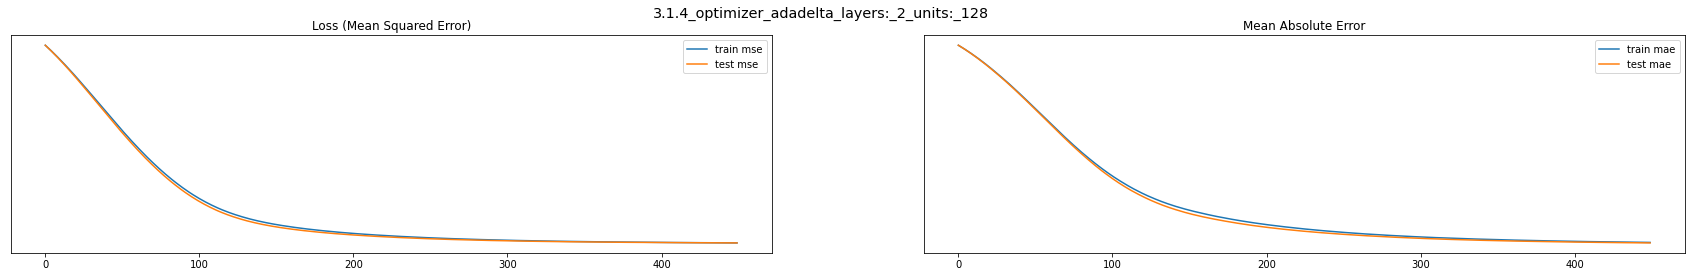

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_2_unit...              19.844   
1  test:_3.1.4_optimizer_adadelta_layers:_2_units...              19.860   
2      3.1.4_optimizer_adadelta_layers:_2_units:_128               0.015   

   mean_absolute_error  r2_score  e_v_score  
0                3.482    93.167     93.167  
1                3.456    93.226     93.226  
2               -0.026    -0.059     -0.059  

Epoch 1: val_loss improved from inf to 0.44421, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_6.hdf5

Epoch 2: val_loss improved from 0.44421 to 0.44398, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_6.hdf5

Epoch 3: val_loss improved from 0.44398 to 0.44374, saving model to /content/drive/MyDrive/Colab N

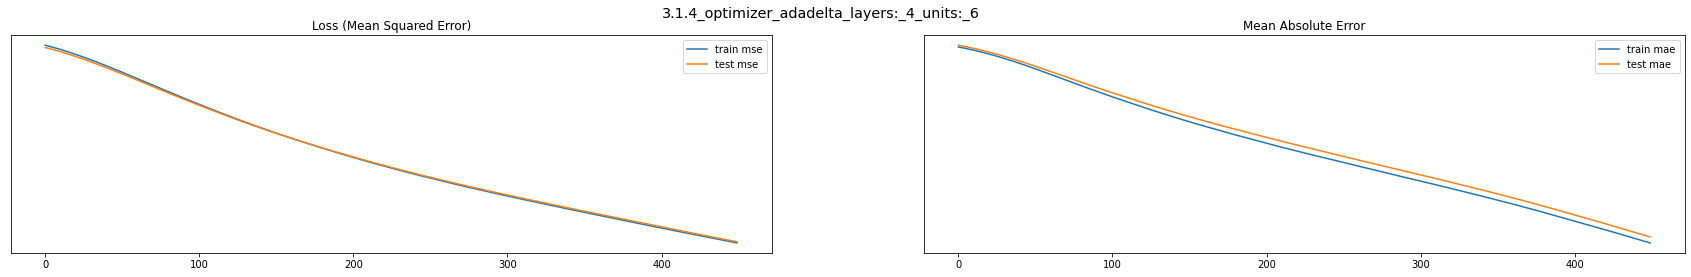

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_4_unit...             262.002   
1  test:_3.1.4_optimizer_adadelta_layers:_4_units:_6             262.603   
2        3.1.4_optimizer_adadelta_layers:_4_units:_6               0.601   

   mean_absolute_error  r2_score  e_v_score  
0               13.316     9.788     15.558  
1               13.384    10.423     15.675  
2                0.068    -0.635     -0.117  

Epoch 1: val_loss improved from inf to 0.35410, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_8.hdf5

Epoch 2: val_loss improved from 0.35410 to 0.35392, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_8.hdf5

Epoch 3: val_loss improved from 0.35392 to 0.35373, saving model to /content/drive/MyDrive/Colab N

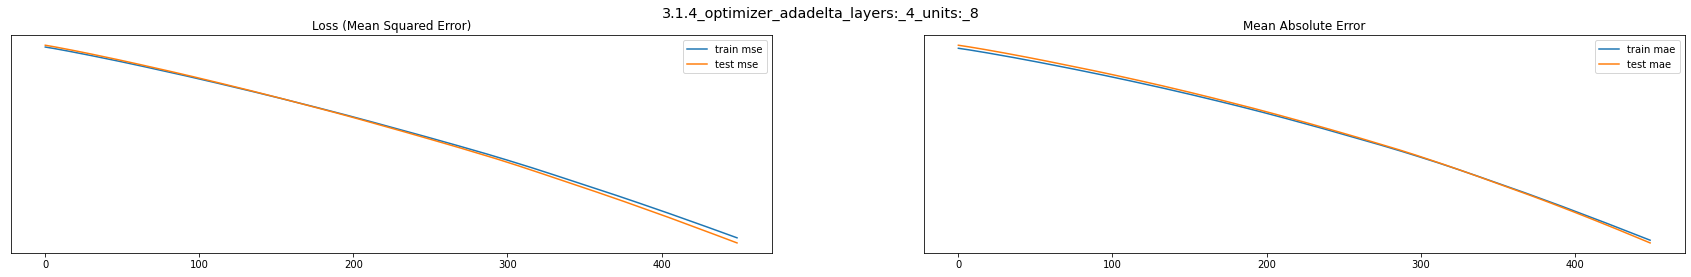

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_4_unit...             172.632   
1  test:_3.1.4_optimizer_adadelta_layers:_4_units:_8             169.838   
2        3.1.4_optimizer_adadelta_layers:_4_units:_8              -2.794   

   mean_absolute_error  r2_score  e_v_score  
0               11.069    40.559     41.778  
1               11.026    42.066     43.482  
2               -0.043    -1.507     -1.704  

Epoch 1: val_loss improved from inf to 0.37115, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_16.hdf5

Epoch 2: val_loss improved from 0.37115 to 0.37096, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_16.hdf5

Epoch 3: val_loss improved from 0.37096 to 0.37076, saving model to /content/drive/MyDrive/Colab

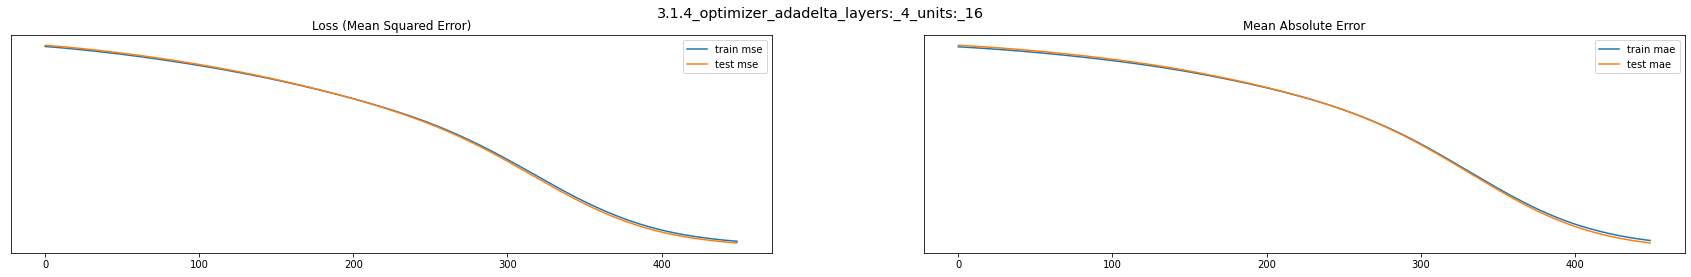

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_4_unit...              39.886   
1  test:_3.1.4_optimizer_adadelta_layers:_4_units...              37.795   
2       3.1.4_optimizer_adadelta_layers:_4_units:_16              -2.091   

   mean_absolute_error  r2_score  e_v_score  
0                4.877    86.266     86.297  
1                4.760    87.108     87.135  
2               -0.118    -0.842     -0.838  

Epoch 1: val_loss improved from inf to 0.35978, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_32.hdf5

Epoch 2: val_loss improved from 0.35978 to 0.35926, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_32.hdf5

Epoch 3: val_loss improved from 0.35926 to 0.35873, saving model to /content/drive/MyDrive/Colab

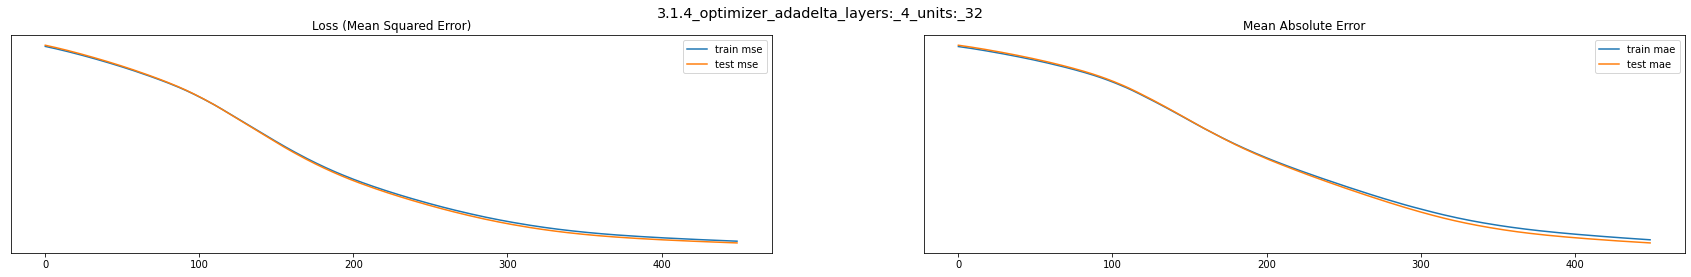

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_4_unit...              39.707   
1  test:_3.1.4_optimizer_adadelta_layers:_4_units...              37.544   
2       3.1.4_optimizer_adadelta_layers:_4_units:_32              -2.163   

   mean_absolute_error  r2_score  e_v_score  
0                5.037    86.328     86.365  
1                4.884    87.193     87.228  
2               -0.153    -0.865     -0.863  

Epoch 1: val_loss improved from inf to 0.35556, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_64.hdf5

Epoch 2: val_loss improved from 0.35556 to 0.35434, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_64.hdf5

Epoch 3: val_loss improved from 0.35434 to 0.35308, saving model to /content/drive/MyDrive/Colab

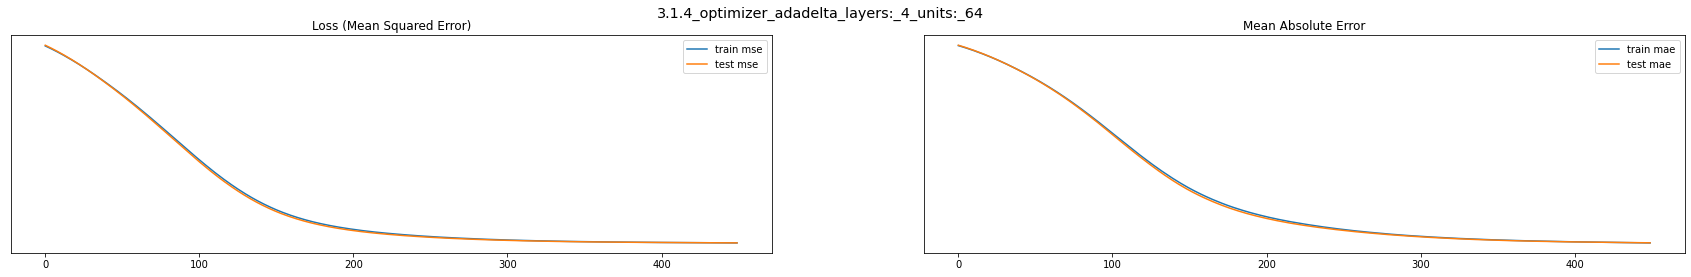

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_4_unit...              20.522   
1  test:_3.1.4_optimizer_adadelta_layers:_4_units...              20.594   
2       3.1.4_optimizer_adadelta_layers:_4_units:_64               0.072   

   mean_absolute_error  r2_score  e_v_score  
0                3.531    92.934     92.935  
1                3.538    92.975     92.975  
2                0.007    -0.041     -0.040  

Epoch 1: val_loss improved from inf to 0.35880, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_128.hdf5

Epoch 2: val_loss improved from 0.35880 to 0.35711, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_4_units:_128.hdf5

Epoch 3: val_loss improved from 0.35711 to 0.35541, saving model to /content/drive/MyDrive/Col

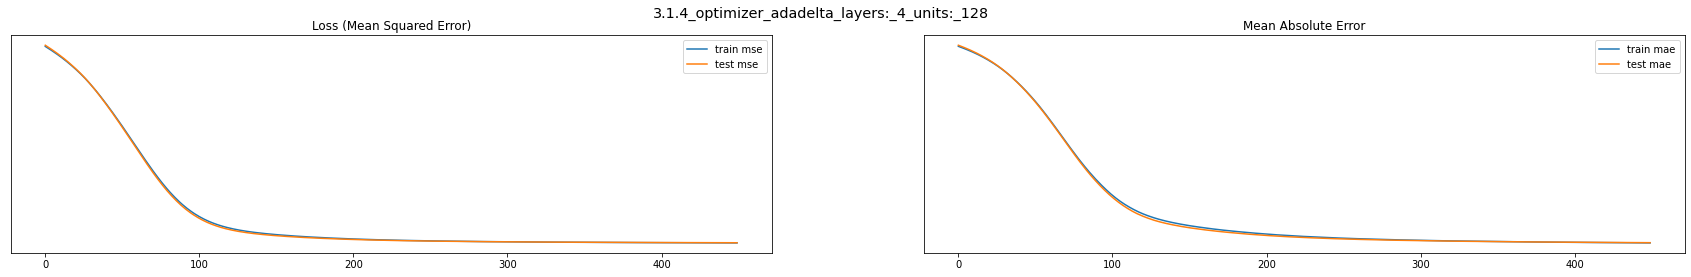

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_4_unit...              18.740   
1  test:_3.1.4_optimizer_adadelta_layers:_4_units...              18.981   
2      3.1.4_optimizer_adadelta_layers:_4_units:_128               0.241   

   mean_absolute_error  r2_score  e_v_score  
0                3.366    93.548     93.548  
1                3.380    93.525     93.526  
2                0.013     0.023      0.022  

Epoch 1: val_loss improved from inf to 0.37989, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_6.hdf5

Epoch 2: val_loss improved from 0.37989 to 0.37979, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_6.hdf5

Epoch 3: val_loss improved from 0.37979 to 0.37969, saving model to /content/drive/MyDrive/Colab N

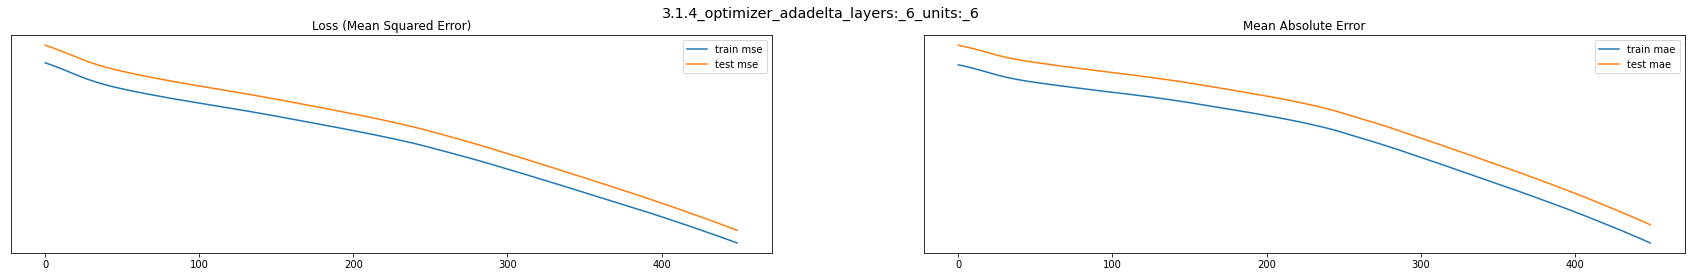

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_6_unit...             275.322   
1  test:_3.1.4_optimizer_adadelta_layers:_6_units:_6             277.297   
2        3.1.4_optimizer_adadelta_layers:_6_units:_6               1.975   

   mean_absolute_error  r2_score  e_v_score  
0               13.989     5.201      9.150  
1               14.069     5.411      9.046  
2                0.080    -0.210      0.104  

Epoch 1: val_loss improved from inf to 0.36459, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_8.hdf5

Epoch 2: val_loss improved from 0.36459 to 0.36446, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_8.hdf5

Epoch 3: val_loss improved from 0.36446 to 0.36433, saving model to /content/drive/MyDrive/Colab N

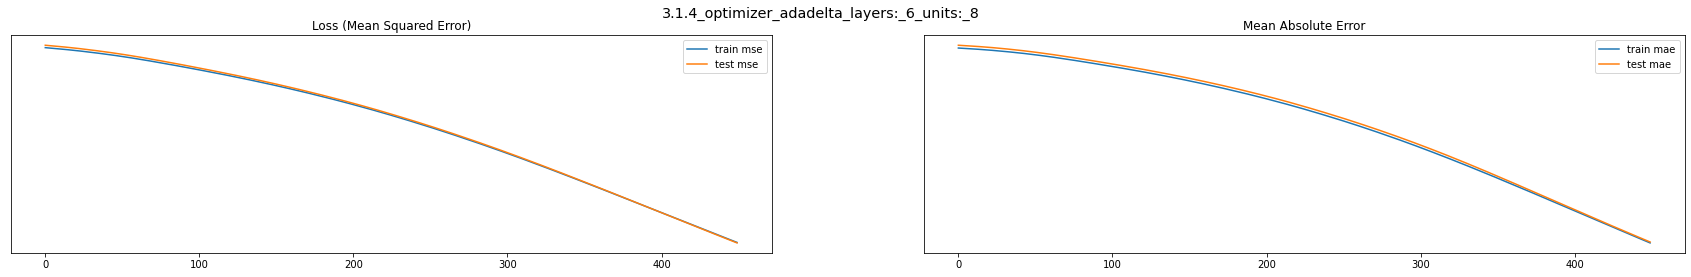

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_6_unit...             142.510   
1  test:_3.1.4_optimizer_adadelta_layers:_6_units:_8             142.379   
2        3.1.4_optimizer_adadelta_layers:_6_units:_8              -0.131   

   mean_absolute_error  r2_score  e_v_score  
0                9.412    50.931     55.743  
1                9.445    51.433     56.068  
2                0.033    -0.502     -0.325  

Epoch 1: val_loss improved from inf to 0.37726, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_16.hdf5

Epoch 2: val_loss improved from 0.37726 to 0.37717, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_16.hdf5

Epoch 3: val_loss improved from 0.37717 to 0.37708, saving model to /content/drive/MyDrive/Colab

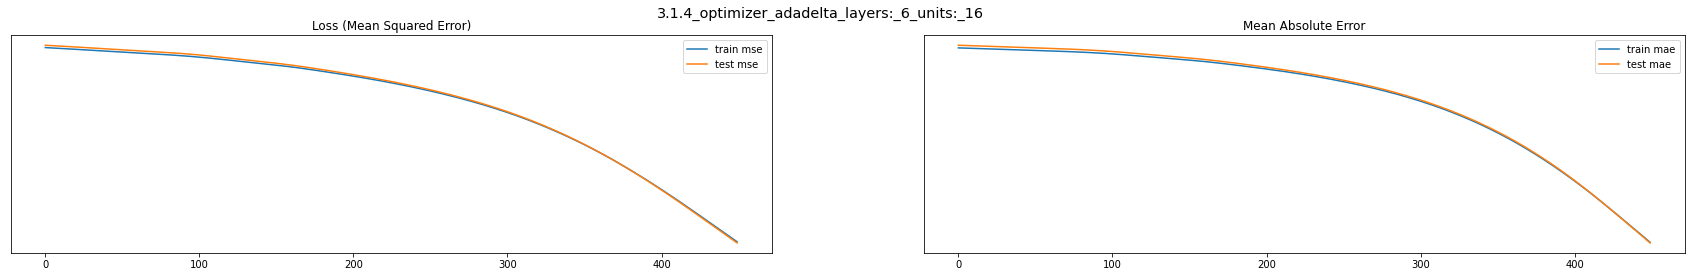

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_6_unit...             133.560   
1  test:_3.1.4_optimizer_adadelta_layers:_6_units...             133.053   
2       3.1.4_optimizer_adadelta_layers:_6_units:_16              -0.507   

   mean_absolute_error  r2_score  e_v_score  
0                9.089    54.013     56.842  
1                9.093    54.614     57.362  
2                0.004    -0.601     -0.520  

Epoch 1: val_loss improved from inf to 0.38548, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_32.hdf5

Epoch 2: val_loss improved from 0.38548 to 0.38509, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_32.hdf5

Epoch 3: val_loss improved from 0.38509 to 0.38467, saving model to /content/drive/MyDrive/Colab

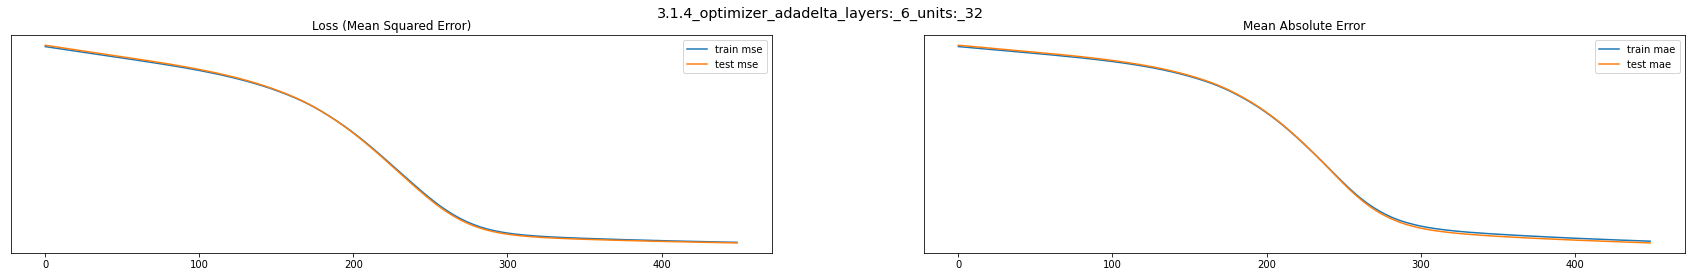

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_6_unit...              29.550   
1  test:_3.1.4_optimizer_adadelta_layers:_6_units...              28.774   
2       3.1.4_optimizer_adadelta_layers:_6_units:_32              -0.776   

   mean_absolute_error  r2_score  e_v_score  
0                4.275    89.825     89.827  
1                4.182    90.185     90.187  
2               -0.093    -0.360     -0.360  

Epoch 1: val_loss improved from inf to 0.37364, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_64.hdf5

Epoch 2: val_loss improved from 0.37364 to 0.37288, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_64.hdf5

Epoch 3: val_loss improved from 0.37288 to 0.37210, saving model to /content/drive/MyDrive/Colab

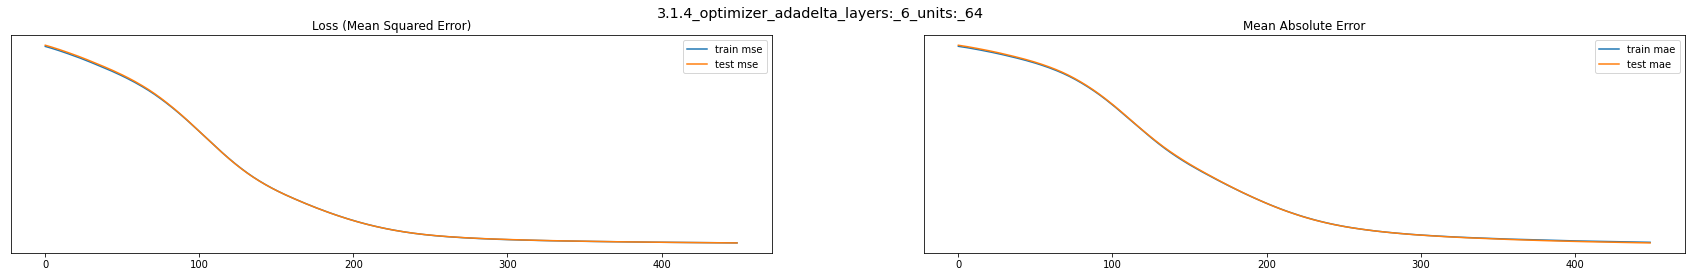

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_6_unit...              21.715   
1  test:_3.1.4_optimizer_adadelta_layers:_6_units...              21.669   
2       3.1.4_optimizer_adadelta_layers:_6_units:_64              -0.045   

   mean_absolute_error  r2_score  e_v_score  
0                3.632    92.523     92.523  
1                3.598    92.608     92.609  
2               -0.034    -0.085     -0.086  

Epoch 1: val_loss improved from inf to 0.38118, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_128.hdf5

Epoch 2: val_loss improved from 0.38118 to 0.37971, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_6_units:_128.hdf5

Epoch 3: val_loss improved from 0.37971 to 0.37823, saving model to /content/drive/MyDrive/Col

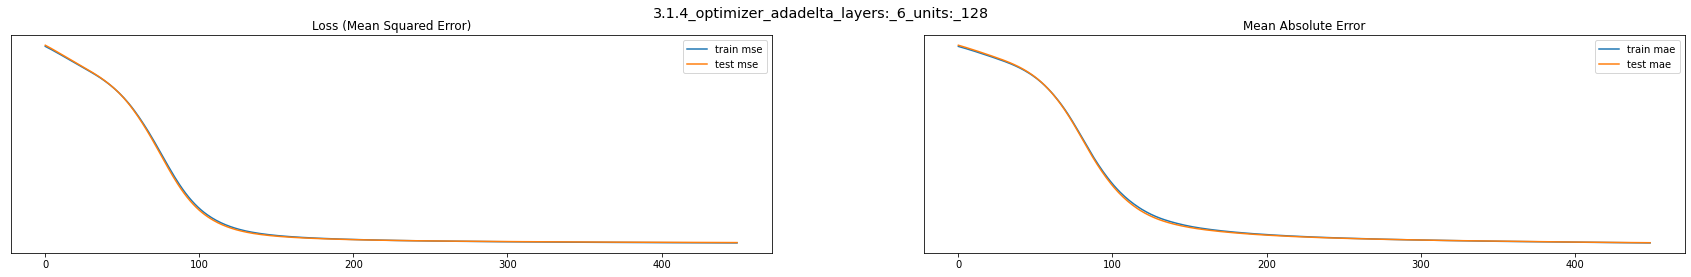

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_6_unit...              19.246   
1  test:_3.1.4_optimizer_adadelta_layers:_6_units...              19.746   
2      3.1.4_optimizer_adadelta_layers:_6_units:_128               0.500   

   mean_absolute_error  r2_score  e_v_score  
0                3.425    93.373     93.374  
1                3.436    93.264     93.264  
2                0.012     0.109      0.110  

Epoch 1: val_loss improved from inf to 0.37690, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_6.hdf5

Epoch 2: val_loss improved from 0.37690 to 0.37685, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_6.hdf5

Epoch 3: val_loss improved from 0.37685 to 0.37679, saving model to /content/drive/MyDrive/Colab N

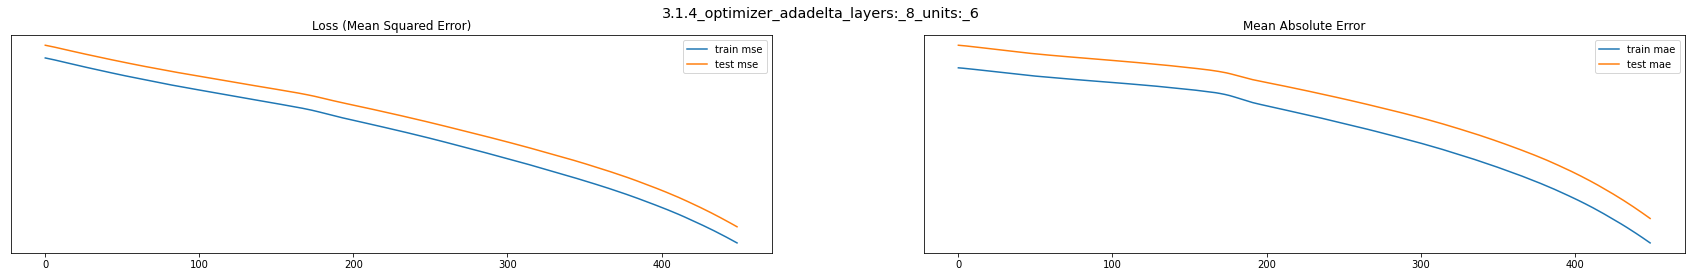

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_8_unit...             273.982   
1  test:_3.1.4_optimizer_adadelta_layers:_8_units:_6             276.426   
2        3.1.4_optimizer_adadelta_layers:_8_units:_6               2.444   

   mean_absolute_error  r2_score  e_v_score  
0               14.266     5.663      5.715  
1               14.343     5.708      5.730  
2                0.078    -0.045     -0.015  

Epoch 1: val_loss improved from inf to 0.37408, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_8.hdf5

Epoch 2: val_loss improved from 0.37408 to 0.37390, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_8.hdf5

Epoch 3: val_loss improved from 0.37390 to 0.37373, saving model to /content/drive/MyDrive/Colab N

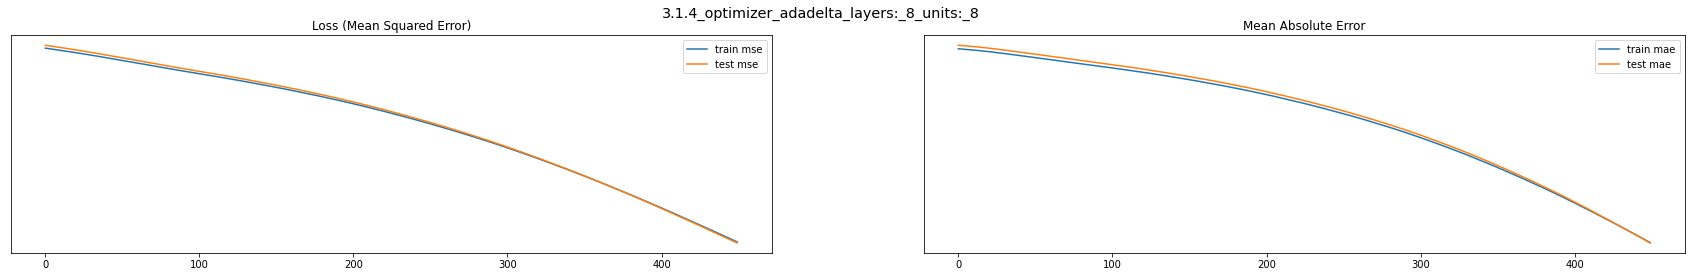

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_8_unit...             184.595   
1  test:_3.1.4_optimizer_adadelta_layers:_8_units:_8             184.195   
2        3.1.4_optimizer_adadelta_layers:_8_units:_8              -0.400   

   mean_absolute_error  r2_score  e_v_score  
0               10.829    36.440     42.200  
1               10.830    37.169     42.726  
2                0.002    -0.729     -0.526  

Epoch 1: val_loss improved from inf to 0.37054, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_16.hdf5

Epoch 2: val_loss improved from 0.37054 to 0.37038, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_16.hdf5

Epoch 3: val_loss improved from 0.37038 to 0.37022, saving model to /content/drive/MyDrive/Colab

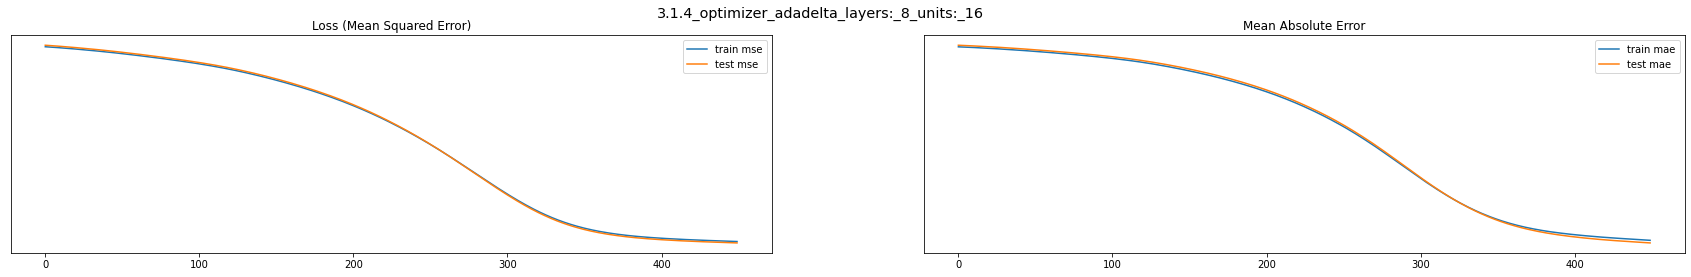

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_8_unit...              42.428   
1  test:_3.1.4_optimizer_adadelta_layers:_8_units...              40.649   
2       3.1.4_optimizer_adadelta_layers:_8_units:_16              -1.779   

   mean_absolute_error  r2_score  e_v_score  
0                5.126    85.391     85.394  
1                5.000    86.134     86.135  
2               -0.125    -0.743     -0.741  

Epoch 1: val_loss improved from inf to 0.37449, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_32.hdf5

Epoch 2: val_loss improved from 0.37449 to 0.37431, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_32.hdf5

Epoch 3: val_loss improved from 0.37431 to 0.37413, saving model to /content/drive/MyDrive/Colab

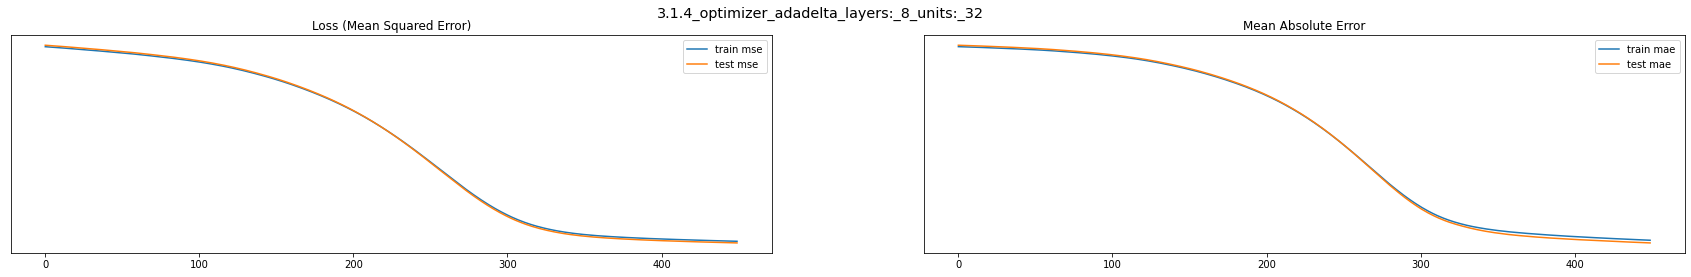

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_8_unit...              35.583   
1  test:_3.1.4_optimizer_adadelta_layers:_8_units...              33.405   
2       3.1.4_optimizer_adadelta_layers:_8_units:_32              -2.179   

   mean_absolute_error  r2_score  e_v_score  
0                4.603    87.748     87.750  
1                4.466    88.605     88.613  
2               -0.137    -0.857     -0.863  

Epoch 1: val_loss improved from inf to 0.37728, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_64.hdf5

Epoch 2: val_loss improved from 0.37728 to 0.37684, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_64.hdf5

Epoch 3: val_loss improved from 0.37684 to 0.37640, saving model to /content/drive/MyDrive/Colab

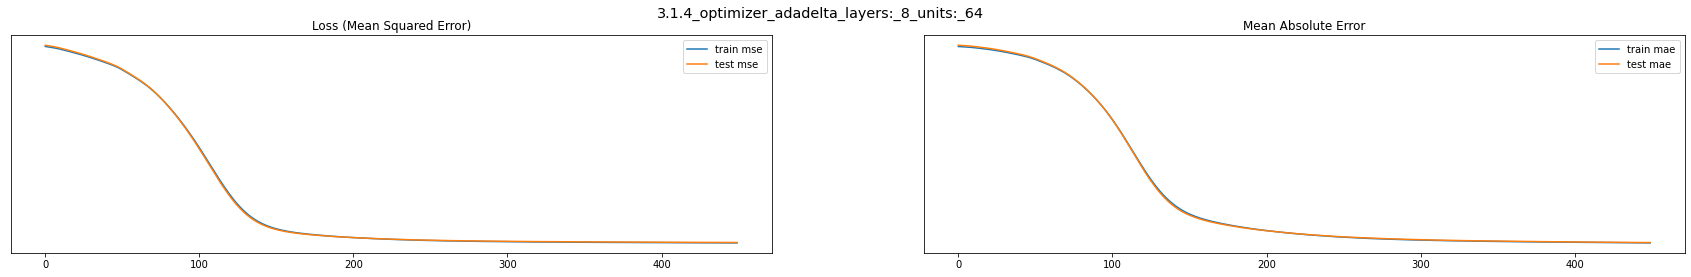

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_8_unit...               19.19   
1  test:_3.1.4_optimizer_adadelta_layers:_8_units...               19.81   
2       3.1.4_optimizer_adadelta_layers:_8_units:_64                0.62   

   mean_absolute_error  r2_score  e_v_score  
0                3.388    93.393     93.394  
1                3.409    93.243     93.244  
2                0.021     0.150      0.150  

Epoch 1: val_loss improved from inf to 0.37171, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_128.hdf5

Epoch 2: val_loss improved from 0.37171 to 0.37140, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_8_units:_128.hdf5

Epoch 3: val_loss improved from 0.37140 to 0.37107, saving model to /content/drive/MyDrive/Col

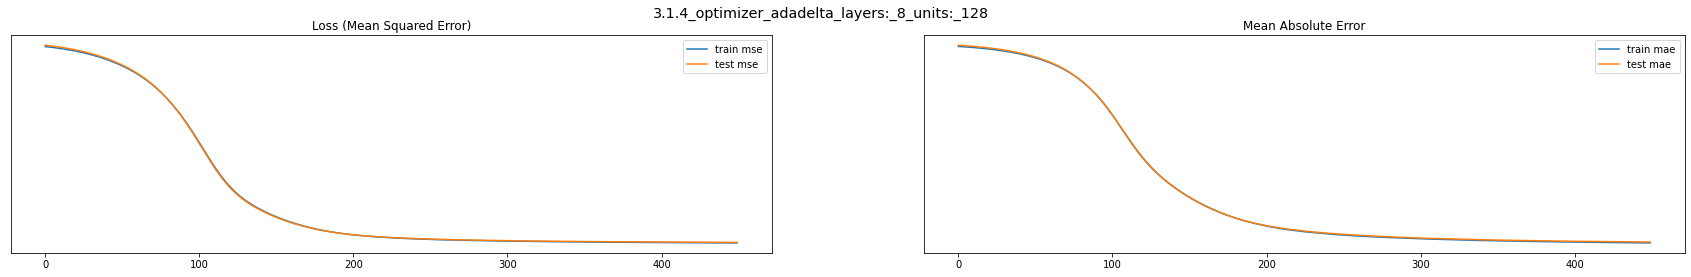

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_8_unit...              18.694   
1  test:_3.1.4_optimizer_adadelta_layers:_8_units...              19.452   
2      3.1.4_optimizer_adadelta_layers:_8_units:_128               0.758   

   mean_absolute_error  r2_score  e_v_score  
0                3.340    93.563     93.564  
1                3.391    93.365     93.365  
2                0.051     0.198      0.199  

Epoch 1: val_loss improved from inf to 0.37343, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_6.hdf5

Epoch 2: val_loss improved from 0.37343 to 0.37338, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_6.hdf5

Epoch 3: val_loss improved from 0.37338 to 0.37334, saving model to /content/drive/MyDrive/Colab

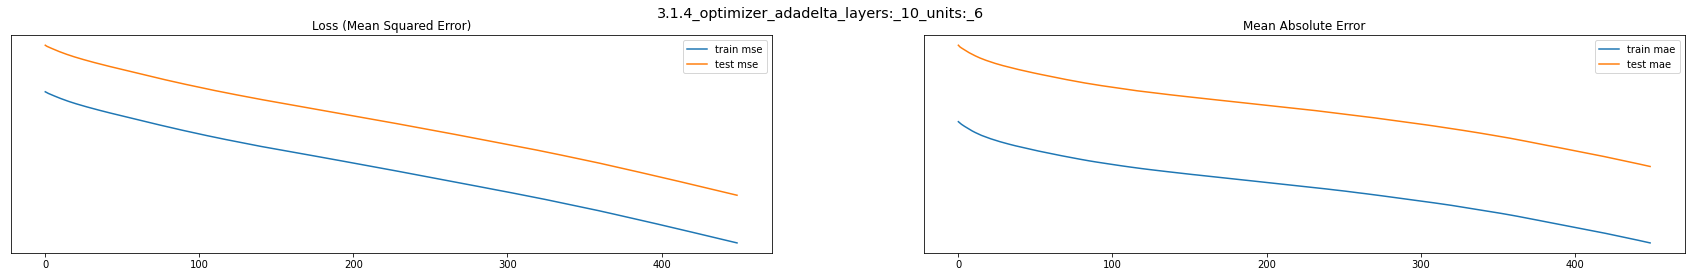

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_10_uni...             292.178   
1  test:_3.1.4_optimizer_adadelta_layers:_10_unit...             294.154   
2       3.1.4_optimizer_adadelta_layers:_10_units:_6               1.977   

   mean_absolute_error  r2_score  e_v_score  
0               14.585    -0.603      1.477  
1               14.658    -0.339      1.490  
2                0.072    -0.264     -0.013  

Epoch 1: val_loss improved from inf to 0.38479, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_8.hdf5

Epoch 2: val_loss improved from 0.38479 to 0.38466, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_8.hdf5

Epoch 3: val_loss improved from 0.38466 to 0.38452, saving model to /content/drive/MyDrive/Colab

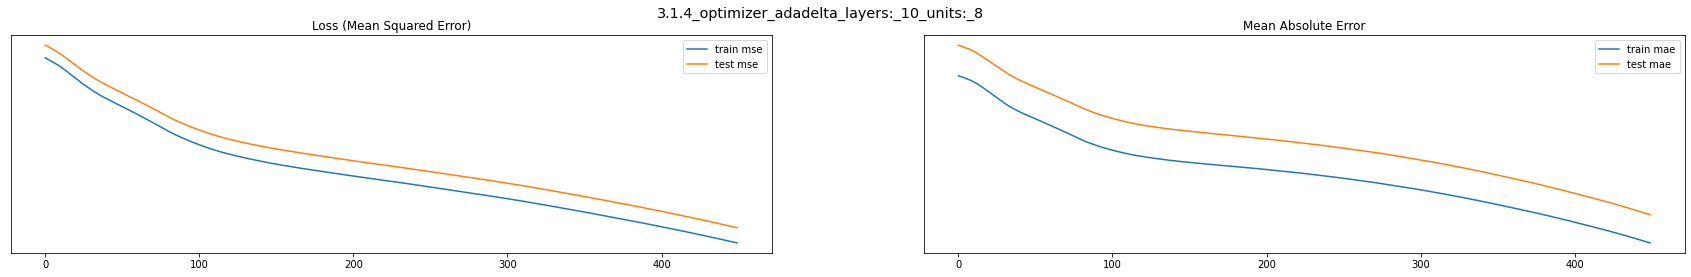

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_10_uni...             283.341   
1  test:_3.1.4_optimizer_adadelta_layers:_10_unit...             285.367   
2       3.1.4_optimizer_adadelta_layers:_10_units:_8               2.027   

   mean_absolute_error  r2_score  e_v_score  
0               14.419     2.440      3.697  
1               14.485     2.658      3.730  
2                0.066    -0.218     -0.033  

Epoch 1: val_loss improved from inf to 0.37239, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_16.hdf5

Epoch 2: val_loss improved from 0.37239 to 0.37228, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_16.hdf5

Epoch 3: val_loss improved from 0.37228 to 0.37217, saving model to /content/drive/MyDrive/Col

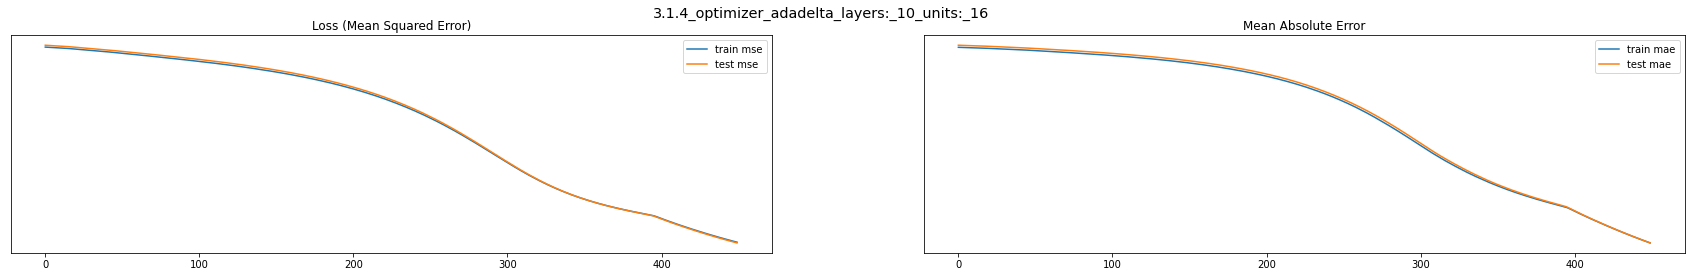

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_10_uni...              97.524   
1  test:_3.1.4_optimizer_adadelta_layers:_10_unit...              97.005   
2      3.1.4_optimizer_adadelta_layers:_10_units:_16              -0.519   

   mean_absolute_error  r2_score  e_v_score  
0                8.105    66.421     70.834  
1                8.115    66.911     71.447  
2                0.010    -0.490     -0.613  

Epoch 1: val_loss improved from inf to 0.37430, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_32.hdf5

Epoch 2: val_loss improved from 0.37430 to 0.37415, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_32.hdf5

Epoch 3: val_loss improved from 0.37415 to 0.37400, saving model to /content/drive/MyDrive/Col

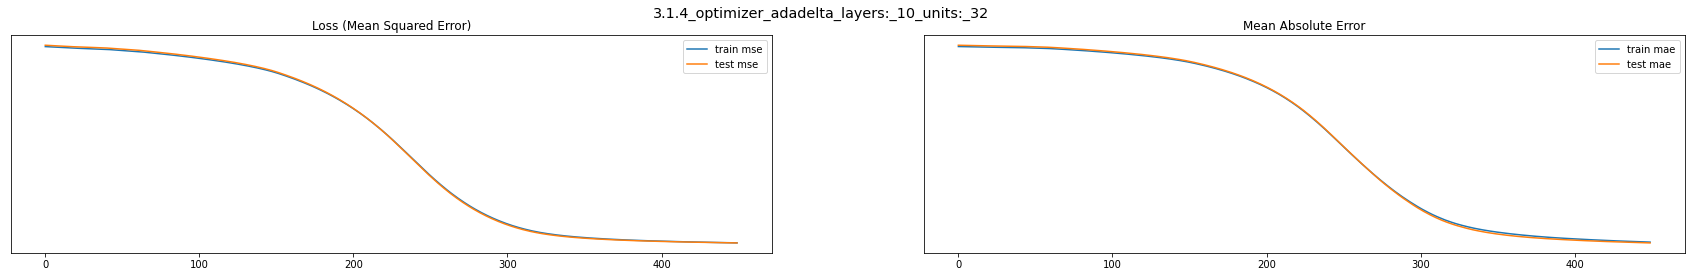

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_10_uni...              24.947   
1  test:_3.1.4_optimizer_adadelta_layers:_10_unit...              24.897   
2      3.1.4_optimizer_adadelta_layers:_10_units:_32              -0.050   

   mean_absolute_error  r2_score  e_v_score  
0                3.863    91.410     91.410  
1                3.820    91.507     91.508  
2               -0.043    -0.097     -0.098  

Epoch 1: val_loss improved from inf to 0.37649, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_64.hdf5

Epoch 2: val_loss improved from 0.37649 to 0.37625, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_64.hdf5

Epoch 3: val_loss improved from 0.37625 to 0.37602, saving model to /content/drive/MyDrive/Col

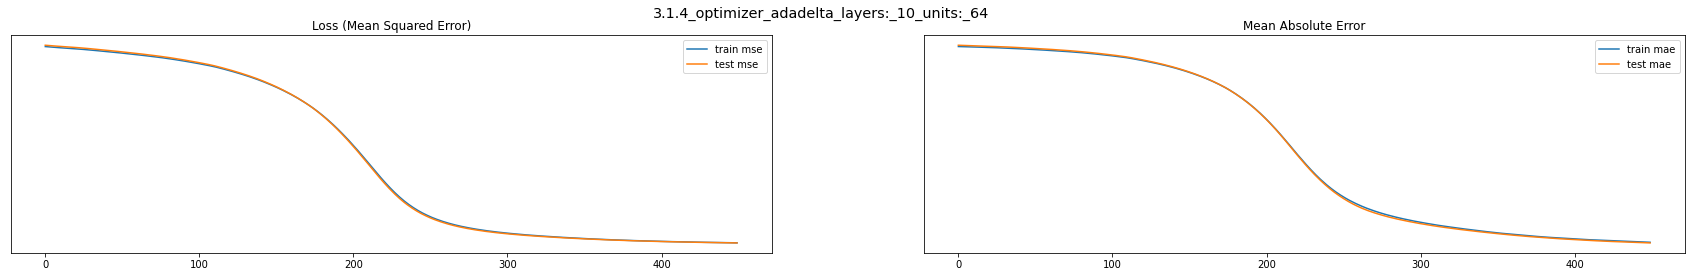

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_10_uni...              21.457   
1  test:_3.1.4_optimizer_adadelta_layers:_10_unit...              21.354   
2      3.1.4_optimizer_adadelta_layers:_10_units:_64              -0.103   

   mean_absolute_error  r2_score  e_v_score  
0                3.609    92.612     92.614  
1                3.574    92.716     92.718  
2               -0.035    -0.104     -0.104  

Epoch 1: val_loss improved from inf to 0.37227, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_128.hdf5

Epoch 2: val_loss improved from 0.37227 to 0.37189, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_10_units:_128.hdf5

Epoch 3: val_loss improved from 0.37189 to 0.37151, saving model to /content/drive/MyDrive/C

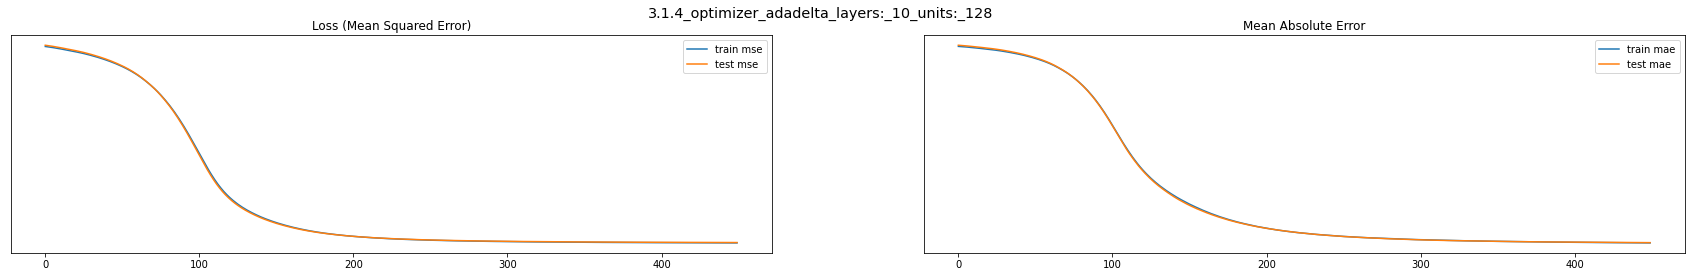

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_10_uni...              17.751   
1  test:_3.1.4_optimizer_adadelta_layers:_10_unit...              18.298   
2     3.1.4_optimizer_adadelta_layers:_10_units:_128               0.547   

   mean_absolute_error  r2_score  e_v_score  
0                3.259    93.888     93.888  
1                3.275    93.758     93.759  
2                0.017     0.130      0.129  

Epoch 1: val_loss improved from inf to 0.37344, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_6.hdf5

Epoch 2: val_loss improved from 0.37344 to 0.37344, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_6.hdf5

Epoch 3: val_loss improved from 0.37344 to 0.37343, saving model to /content/drive/MyDrive/Colab

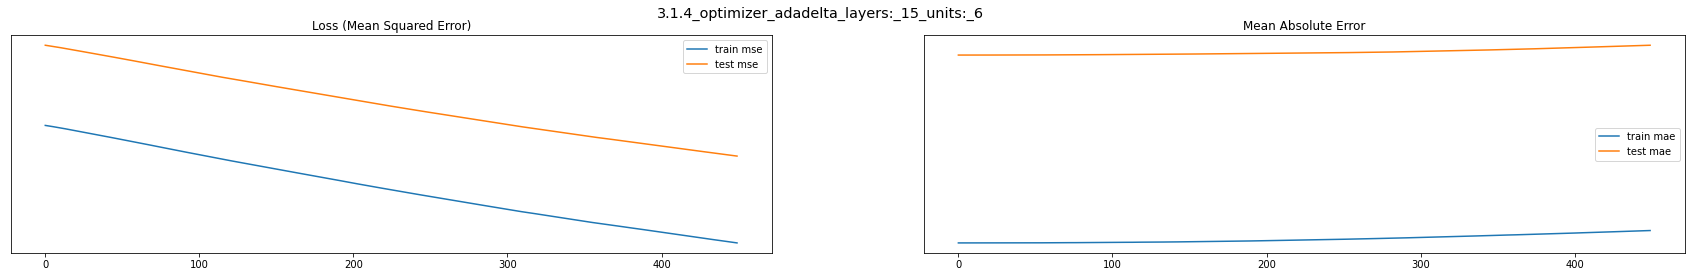

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_15_uni...             295.593   
1  test:_3.1.4_optimizer_adadelta_layers:_15_unit...             297.687   
2       3.1.4_optimizer_adadelta_layers:_15_units:_6               2.094   

   mean_absolute_error  r2_score  e_v_score  
0               14.704    -1.778        0.0  
1               14.776    -1.544        0.0  
2                0.071    -0.234        0.0  

Epoch 1: val_loss improved from inf to 0.37345, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_8.hdf5

Epoch 2: val_loss improved from 0.37345 to 0.37337, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_8.hdf5

Epoch 3: val_loss improved from 0.37337 to 0.37331, saving model to /content/drive/MyDrive/Colab

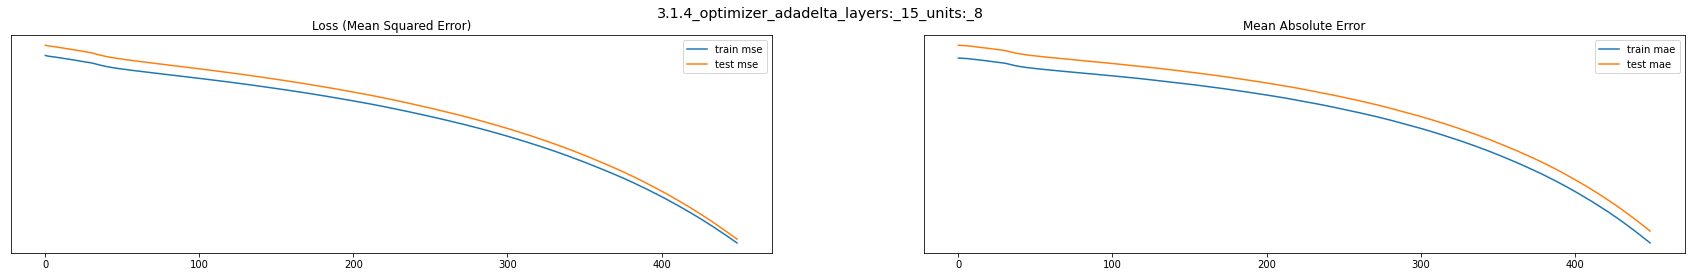

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_15_uni...             264.012   
1  test:_3.1.4_optimizer_adadelta_layers:_15_unit...             264.813   
2       3.1.4_optimizer_adadelta_layers:_15_units:_8               0.801   

   mean_absolute_error  r2_score  e_v_score  
0               13.661     9.095     12.488  
1               13.731     9.669     12.798  
2                0.070    -0.574     -0.310  

Epoch 1: val_loss improved from inf to 0.37334, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_16.hdf5

Epoch 2: val_loss improved from 0.37334 to 0.37308, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_16.hdf5

Epoch 3: val_loss improved from 0.37308 to 0.37267, saving model to /content/drive/MyDrive/Col

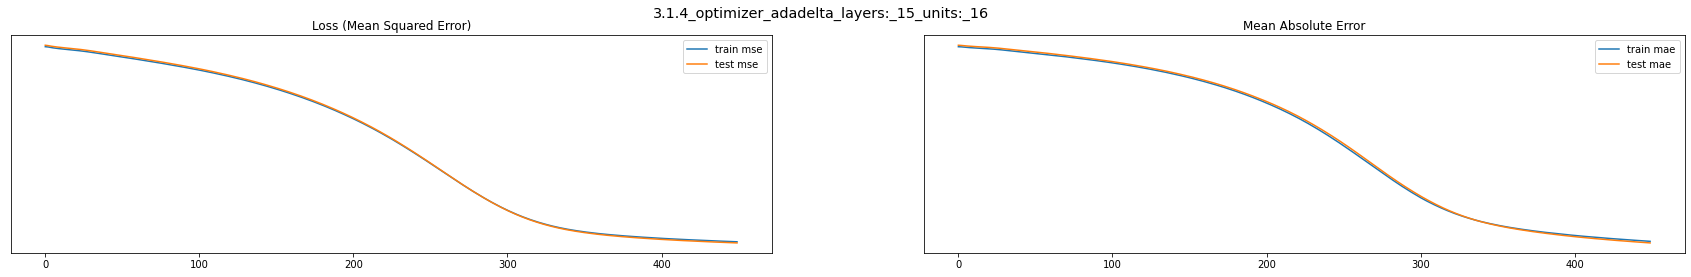

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_15_uni...              44.650   
1  test:_3.1.4_optimizer_adadelta_layers:_15_unit...              43.223   
2      3.1.4_optimizer_adadelta_layers:_15_units:_16              -1.427   

   mean_absolute_error  r2_score  e_v_score  
0                5.295    84.626     84.666  
1                5.222    85.256     85.285  
2               -0.074    -0.630     -0.619  

Epoch 1: val_loss improved from inf to 0.37345, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_32.hdf5

Epoch 2: val_loss improved from 0.37345 to 0.37337, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_32.hdf5

Epoch 3: val_loss improved from 0.37337 to 0.37330, saving model to /content/drive/MyDrive/Col

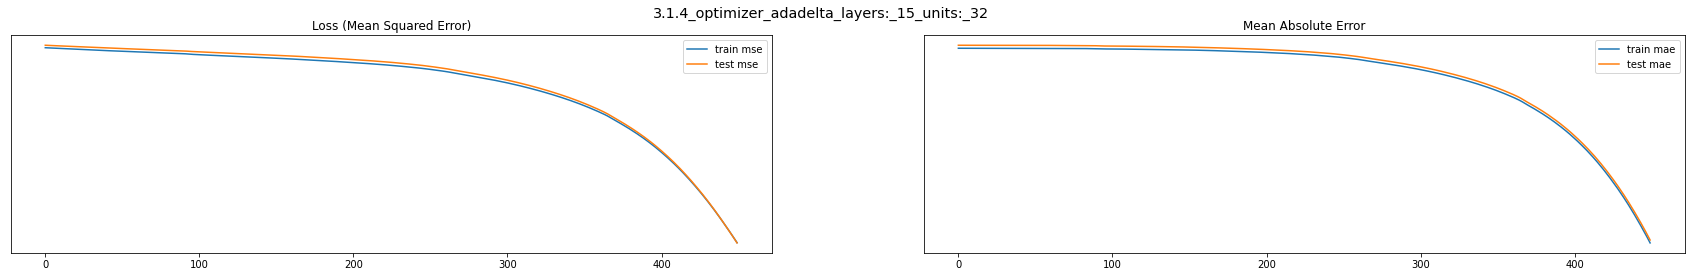

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_15_uni...             148.113   
1  test:_3.1.4_optimizer_adadelta_layers:_15_unit...             148.862   
2      3.1.4_optimizer_adadelta_layers:_15_units:_32               0.750   

   mean_absolute_error  r2_score  e_v_score  
0               10.013    49.002     49.057  
1               10.120    49.221     49.253  
2                0.107    -0.219     -0.196  

Epoch 1: val_loss improved from inf to 0.37377, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_64.hdf5

Epoch 2: val_loss improved from 0.37377 to 0.37356, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_64.hdf5

Epoch 3: val_loss improved from 0.37356 to 0.37330, saving model to /content/drive/MyDrive/Col

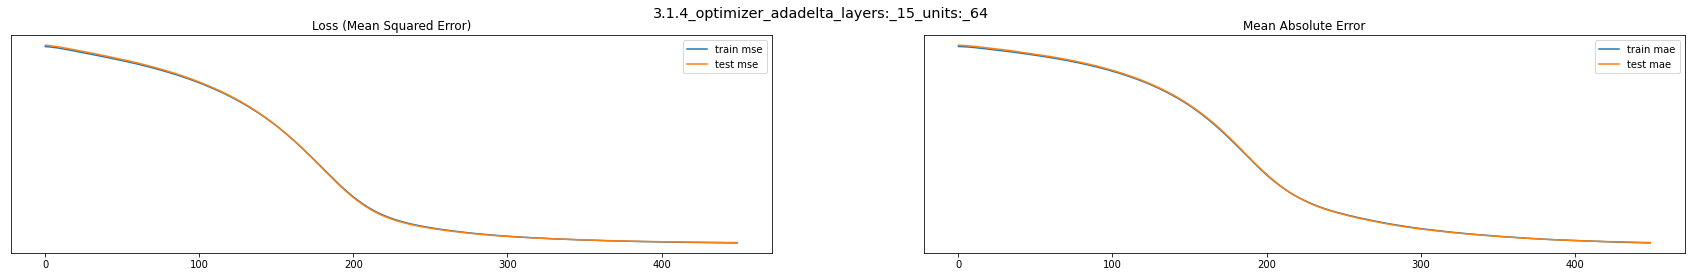

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_15_uni...              19.189   
1  test:_3.1.4_optimizer_adadelta_layers:_15_unit...              19.673   
2      3.1.4_optimizer_adadelta_layers:_15_units:_64               0.483   

   mean_absolute_error  r2_score  e_v_score  
0                3.394    93.393     93.397  
1                3.416    93.289     93.290  
2                0.022     0.104      0.107  

Epoch 1: val_loss improved from inf to 0.37325, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_128.hdf5

Epoch 2: val_loss improved from 0.37325 to 0.37301, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_15_units:_128.hdf5

Epoch 3: val_loss improved from 0.37301 to 0.37277, saving model to /content/drive/MyDrive/C

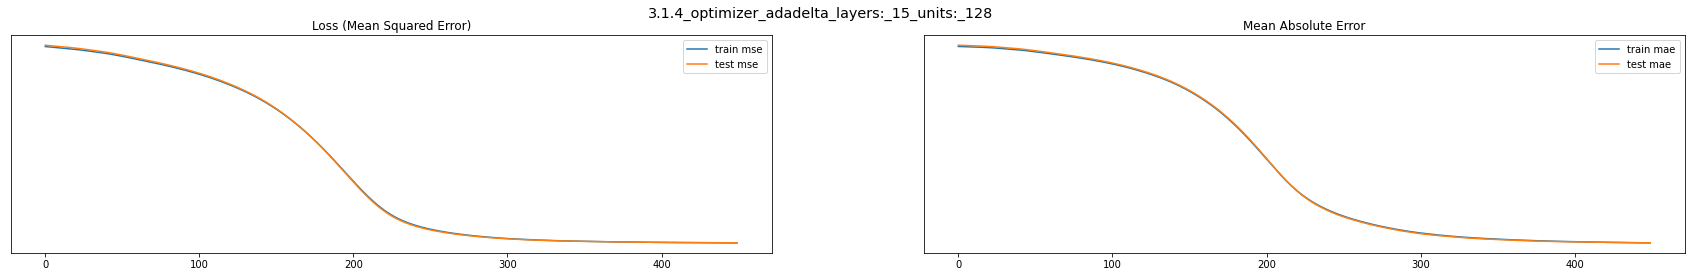

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_15_uni...              17.913   
1  test:_3.1.4_optimizer_adadelta_layers:_15_unit...              18.108   
2     3.1.4_optimizer_adadelta_layers:_15_units:_128               0.194   

   mean_absolute_error  r2_score  e_v_score  
0                3.275    93.832     93.833  
1                3.284    93.823     93.827  
2                0.009     0.009      0.006  

Epoch 1: val_loss improved from inf to 0.37341, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_6.hdf5

Epoch 2: val_loss improved from 0.37341 to 0.37340, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_6.hdf5

Epoch 3: val_loss improved from 0.37340 to 0.37338, saving model to /content/drive/MyDrive/Colab

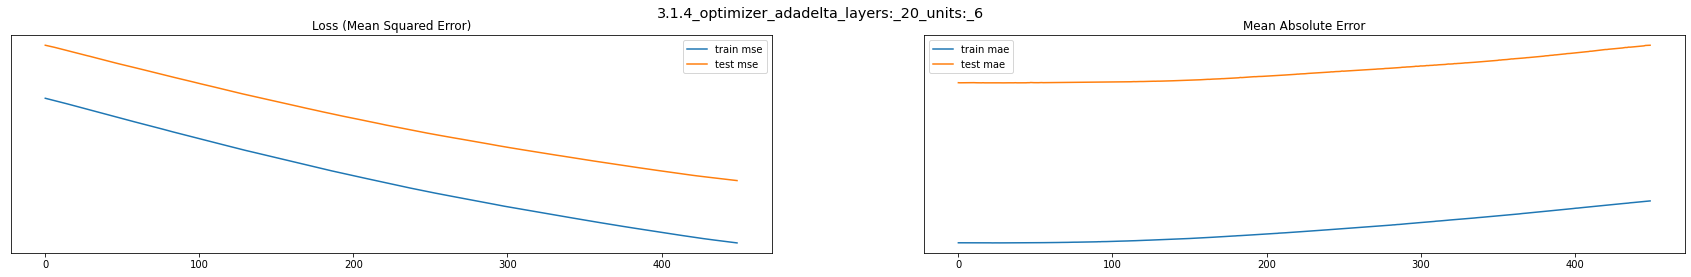

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_20_uni...             293.149   
1  test:_3.1.4_optimizer_adadelta_layers:_20_unit...             295.416   
2       3.1.4_optimizer_adadelta_layers:_20_units:_6               2.268   

   mean_absolute_error  r2_score  e_v_score  
0               14.718    -0.937      0.022  
1               14.788    -0.770      0.023  
2                0.070    -0.167     -0.001  

Epoch 1: val_loss improved from inf to 0.37342, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_8.hdf5

Epoch 2: val_loss improved from 0.37342 to 0.37339, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_8.hdf5

Epoch 3: val_loss improved from 0.37339 to 0.37337, saving model to /content/drive/MyDrive/Colab

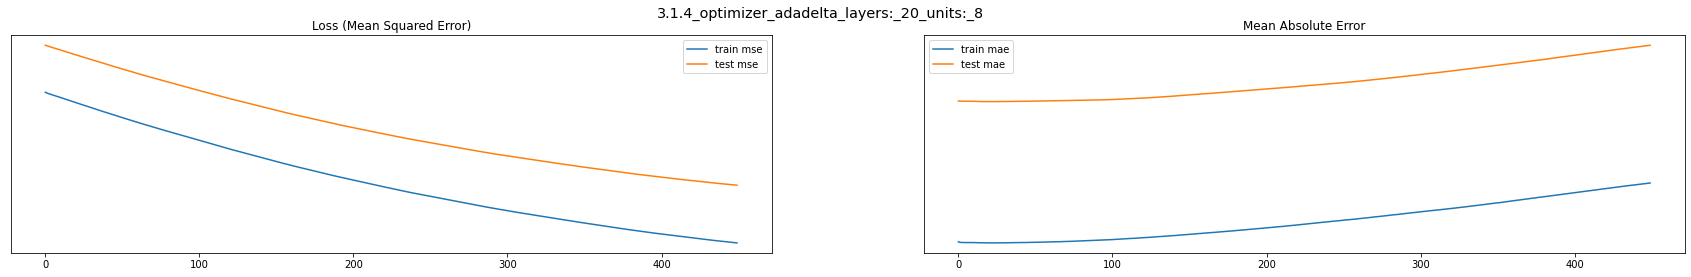

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_20_uni...             292.290   
1  test:_3.1.4_optimizer_adadelta_layers:_20_unit...             294.642   
2       3.1.4_optimizer_adadelta_layers:_20_units:_8               2.352   

   mean_absolute_error  r2_score  e_v_score  
0                14.73    -0.641      0.015  
1                14.80    -0.506      0.015  
2                 0.07    -0.135      0.000  

Epoch 1: val_loss improved from inf to 0.37340, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_16.hdf5

Epoch 2: val_loss improved from 0.37340 to 0.37337, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_16.hdf5

Epoch 3: val_loss improved from 0.37337 to 0.37333, saving model to /content/drive/MyDrive/Col

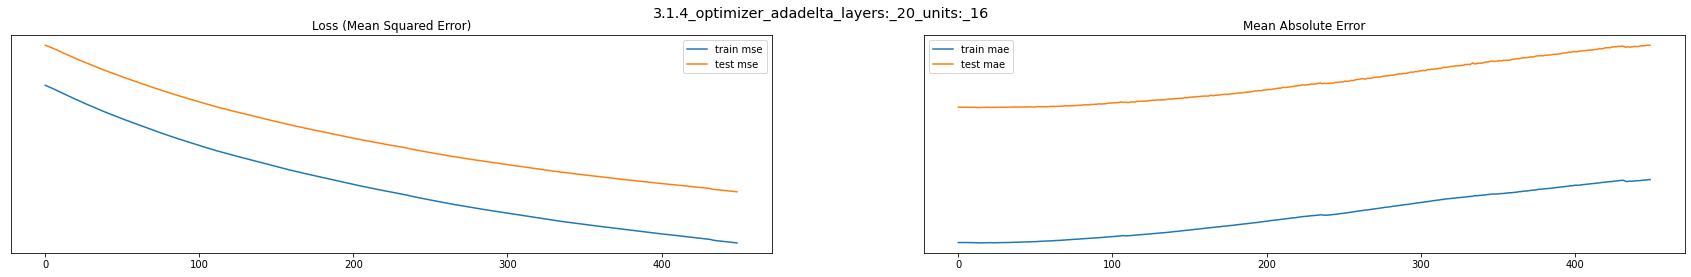

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_20_uni...             290.870   
1  test:_3.1.4_optimizer_adadelta_layers:_20_unit...             293.318   
2      3.1.4_optimizer_adadelta_layers:_20_units:_16               2.448   

   mean_absolute_error  r2_score  e_v_score  
0               14.733    -0.152      0.195  
1               14.805    -0.054      0.198  
2                0.072    -0.098     -0.003  

Epoch 1: val_loss improved from inf to 0.37335, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_32.hdf5

Epoch 2: val_loss improved from 0.37335 to 0.37322, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_32.hdf5

Epoch 3: val_loss improved from 0.37322 to 0.37307, saving model to /content/drive/MyDrive/Col

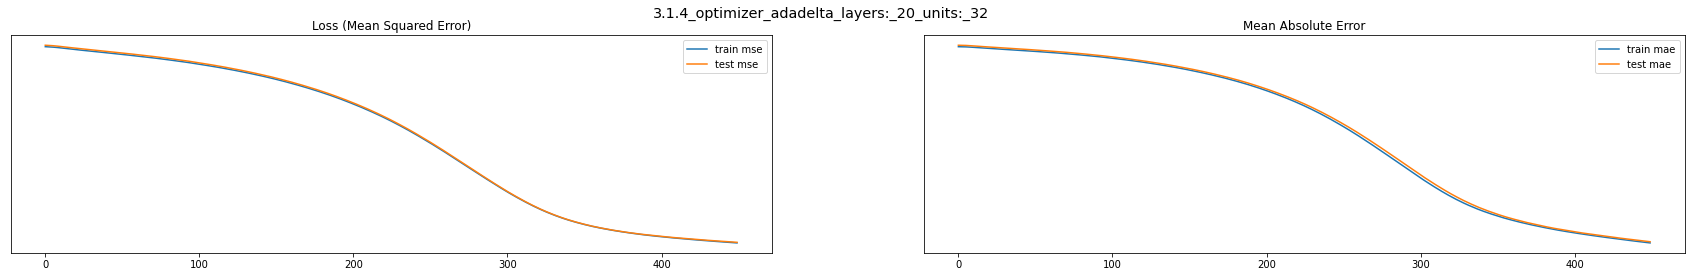

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_20_uni...              41.012   
1  test:_3.1.4_optimizer_adadelta_layers:_20_unit...              41.868   
2      3.1.4_optimizer_adadelta_layers:_20_units:_32               0.856   

   mean_absolute_error  r2_score  e_v_score  
0                5.064    85.879     85.879  
1                5.127    85.718     85.720  
2                0.063     0.161      0.159  

Epoch 1: val_loss improved from inf to 0.37329, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_64.hdf5

Epoch 2: val_loss improved from 0.37329 to 0.37309, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_64.hdf5

Epoch 3: val_loss improved from 0.37309 to 0.37286, saving model to /content/drive/MyDrive/Col

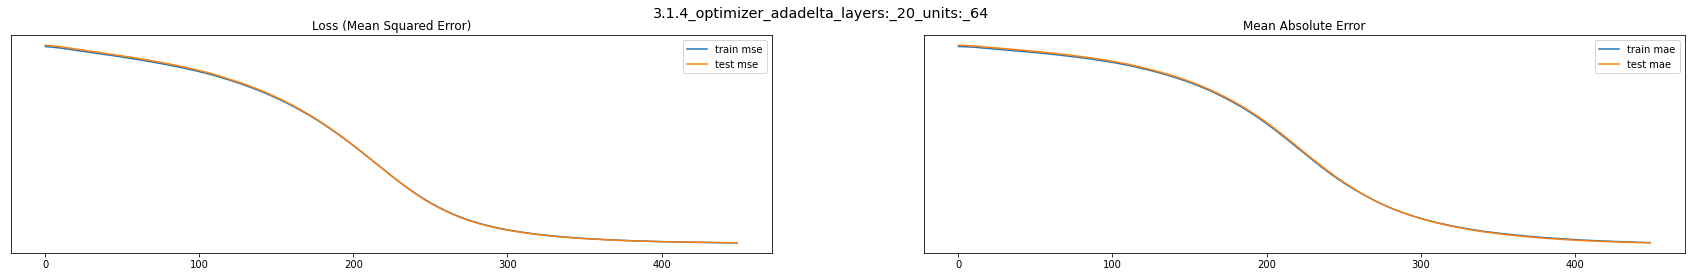

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_20_uni...              19.153   
1  test:_3.1.4_optimizer_adadelta_layers:_20_unit...              19.348   
2      3.1.4_optimizer_adadelta_layers:_20_units:_64               0.195   

   mean_absolute_error  r2_score  e_v_score  
0                3.395    93.405     93.412  
1                3.380    93.400     93.403  
2               -0.015     0.005      0.009  

Epoch 1: val_loss improved from inf to 0.37330, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_128.hdf5

Epoch 2: val_loss improved from 0.37330 to 0.37313, saving model to /content/drive/MyDrive/Colab Notebooks/4.ML_ANN_Project/weights_and_models/resnet-weights_3.1.4_optimizer_adadelta_layers:_20_units:_128.hdf5

Epoch 3: val_loss improved from 0.37313 to 0.37289, saving model to /content/drive/MyDrive/C

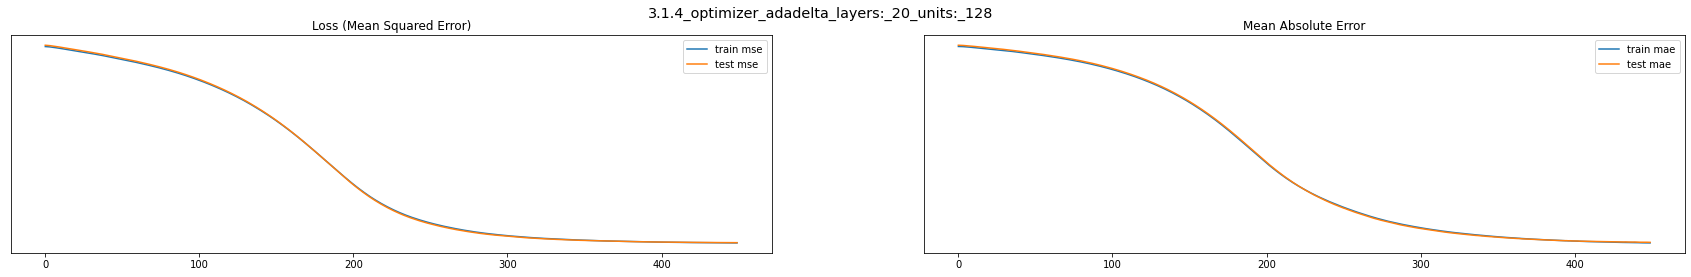

                                                type  mean_squared_error  \
0  train:_3.1.4_optimizer_adadelta_layers:_20_uni...              17.462   
1  test:_3.1.4_optimizer_adadelta_layers:_20_unit...              17.835   
2     3.1.4_optimizer_adadelta_layers:_20_units:_128               0.374   

   mean_absolute_error  r2_score  e_v_score  
0                3.194    93.988     93.994  
1                3.232    93.916     93.922  
2                0.037     0.072      0.072  


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
nlayers = [2,4,6,8,10,15,20]
units = [6,8,16,32,64,128]
for nl in nlayers:
  for u in units:
    complete_run (f"3.1.4_optimizer_adadelta_layers:_{nl}_units:_{u}", pipe,opt = 'adadelta', n_layers = nl, unt = u)

In [ ]:
show_results(False)

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 42 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 17.462 
 17.835 
 0.374 
 
 
 36 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 17.913 
 18.108 
 0.194 
 
 
 30 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 17.751 
 18.298 
 0.547 
 
 
 12 
 3.1.4_optimizer_adadelta_layers:_4_units:_128 
 18.740 
 18.981 
 0.241 
 
 
 41 
 3.1.4_optimizer_adadelta_layers:_20_units:_64 
 19.153 
 19.348 
 0.195 
 
 
 24 
 3.1.4_optimizer_adadelta_layers:_8_units:_128 
 18.694 
 19.452 
 0.758 
 
 
 35 
 3.1.4_optimizer_adadelta_layers:_15_units:_64 
 19.189 
 19.673 
 0.483 
 
 
 18 
 3.1.4_optimizer_adadelta_layers:_6_units:_128 
 19.246 
 19.746 
 0.500 
 
 
 23 
 3.1.4_optimizer_adadelta_layers:_8_units:_64 
 19.190 
 19.810 
 0.620 
 
 
 6 
 3.1.4_optimizer_adadelta_layers:_2_units:_128 
 19.844 
 19.860 
 0.015 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_4_units:_64 
 20.522 
 20.594 
 0.072 
 
 
 29 
 3.1.4_optimizer_adadelta_layers:_10_units:_64 
 21.457 
 21.354 
 -0.103 
 
 
 17 
 3.1.4_optimizer_adadelta_layers:_6_units:_64 
 21.715 
 21.669 
 -0.045 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 0.716 
 
 
 5 
 3.1.4_optimizer_adadelta_layers:_2_units:_64 
 23.276 
 22.654 
 -0.622 
 
 
 28 
 3.1.4_optimizer_adadelta_layers:_10_units:_32 
 24.947 
 24.897 
 -0.050 
 
 
 16 
 3.1.4_optimizer_adadelta_layers:_6_units:_32 
 29.550 
 28.774 
 -0.776 
 
 
 4 
 3.1.4_optimizer_adadelta_layers:_2_units:_32 
 33.125 
 31.301 
 -1.824 
 
 
 22 
 3.1.4_optimizer_adadelta_layers:_8_units:_32 
 35.583 
 33.405 
 -2.179 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_4_units:_32 
 39.707 
 37.544 
 -2.163 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_4_units:_16 
 39.886 
 37.795 
 -2.091 
 
 
 21 
 3.1.4_optimizer_adadelta_layers:_8_units:_16 
 42.428 
 40.649 
 -1.779 
 
 
 40 
 3.1.4_optimizer_adadelta_layers:_20_units:_32 
 41.012 
 41.868 
 0.856 
 
 
 33 
 3.1.4_optimizer_adadelta_layers:_15_units:_16 
 44.650 
 43.223 
 -1.427 
 
 
 3 
 3.1.4_optimizer_adadelta_layers:_2_units:_16 
 96.637 
 91.927 
 -4.710 
 
 
 27 
 3.1.4_optimizer_adadelta_layers:_10_units:_16 
 97.524 
 97.005 
 -0.519 
 
 
 15 
 3.1.4_optimizer_adadelta_layers:_6_units:_16 
 133.560 
 133.053 
 -0.507 
 
 
 14 
 3.1.4_optimizer_adadelta_layers:_6_units:_8 
 142.510 
 142.379 
 -0.131 
 
 
 34 
 3.1.4_optimizer_adadelta_layers:_15_units:_32 
 148.113 
 148.862 
 0.750 
 
 
 8 
 3.1.4_optimizer_adadelta_layers:_4_units:_8 
 172.632 
 169.838 
 -2.794 
 
 
 20 
 3.1.4_optimizer_adadelta_layers:_8_units:_8 
 184.595 
 184.195 
 -0.400 
 
 
 2 
 3.1.4_optimizer_adadelta_layers:_2_units:_8 
 249.028 
 251.974 
 2.946 
 
 
 1 
 3.1.4_optimizer_adadelta_layers:_2_units:_6 
 262.440 
 261.009 
 -1.431 
 
 
 7 
 3.1.4_optimizer_adadelta_layers:_4_units:_6 
 262.002 
 262.603 
 0.601 
 
 
 32 
 3.1.4_optimizer_adadelta_layers:_15_units:_8 
 264.012 
 264.813 
 0.801 
 
 
 19 
 3.1.4_optimizer_adadelta_layers:_8_units:_6 
 273.982 
 276.426 
 2.444 
 
 
 13 
 3.1.4_optimizer_adadelta_layers:_6_units:_6 
 275.322 
 277.297 
 1.975 
 
 
 26 
 3.1.4_optimizer_adadelta_layers:_10_units:_8 
 283.341 
 285.367 
 2.027 
 
 
 39 
 3.1.4_optimizer_adadelta_layers:_20_units:_16 
 290.870 
 293.318 
 2.448 
 
 
 25 
 3.1.4_optimizer_adadelta_layers:_10_units:_6 
 292.178 
 294.154 
 1.977 
 
 
 38 
 3.1.4_optimizer_adadelta_layers:_20_units:_8 
 292.290 
 294.642 
 2.352 
 
 
 37 
 3.1.4_optimizer_adadelta_layers:_20_units:_6 
 293.149 
 295.416 
 2.268 
 
 
 31 
 3.1.4_optimizer_adadelta_layers:_15_units:_6 
 295.593 
 297.687 
 2.094 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 42 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 3.194 
 3.232 
 0.037 
 
 
 30 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 3.259 
 3.275 
 0.017 
 
 
 36 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 3.275 
 3.284 
 0.009 
 
 
 41 
 3.1.4_optimizer_adadelta_layers:_20_units:_64 
 3.395 


<Figure size 2880x1080 with 0 Axes>

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 difference 
 
 
 
 
 3 
 No3.1.1_Adam_layers:_2_units:_32 
 12.987 
 15.232 
 2.245 
 
 
 4 
 No3.1.1_Adam_layers:_6_units:_32 
 12.322 
 15.302 
 2.980 
 
 
 2 
 No3.1.1_Adam_layers:_6_units:_16 
 13.874 
 15.533 
 1.658 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 15.029 
 16.038 
 1.009 
 
 
 6 
 3.1.2_Adagrad_layers:_20_units:_128 
 14.601 
 16.052 
 1.450 
 
 
 5 
 3.1.2_Adagrad_layers:_15_units:_128 
 15.314 
 16.187 
 0.873 
 
 
 7 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 15.106 
 16.218 
 1.112 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 16.928 
 17.442 
 0.514 
 
 
 0 
 base_ann 
 16.975 
 17.756 
 0.781 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 17.462 
 17.835 
 0.374 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 17.913 
 18.108 
 0.194 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 17.751 
 18.298 
 0.547 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_6_units:_32 
 2.598 
 2.888 
 0.290 
 
 
 3 
 No3.1.1_Adam_layers:_2_units:_32 
 2.699 
 2.915 
 0.216 
 
 
 2 
 No3.1.1_Adam_layers:_6_units:_16 
 2.790 
 2.947 
 0.157 
 
 
 6 
 3.1.2_Adagrad_layers:_20_units:_128 
 2.903 
 3.042 
 0.140 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 2.949 
 3.050 
 0.101 
 
 
 7 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 2.955 
 3.072 
 0.117 
 
 
 5 
 3.1.2_Adagrad_layers:_15_units:_128 
 2.986 
 3.088 
 0.102 
 
 
 0 
 base_ann 
 3.156 
 3.207 
 0.051 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 3.180 
 3.231 
 0.051 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 3.194 
 3.232 
 0.037 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 3.259 
 3.275 
 0.017 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 3.275 
 3.284 
 0.009 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 difference 
 
 
 
 
 3 
 No3.1.1_Adam_layers:_2_units:_32 
 95.528 
 94.804 
 0.724 
 
 
 4 
 No3.1.1_Adam_layers:_6_units:_32 
 95.757 
 94.780 
 0.977 
 
 
 2 
 No3.1.1_Adam_layers:_6_units:_16 
 95.223 
 94.702 
 0.521 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 94.825 
 94.529 
 0.296 
 
 
 6 
 3.1.2_Adagrad_layers:_20_units:_128 
 94.972 
 94.525 
 0.447 
 
 
 5 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.727 
 94.478 
 0.249 
 
 
 7 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 94.799 
 94.468 
 0.331 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.050 
 0.122 
 
 
 0 
 base_ann 
 94.155 
 93.943 
 0.212 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 93.988 
 93.916 
 0.072 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 93.832 
 93.823 
 0.009 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 93.888 
 93.758 
 0.130 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 difference 
 
 
 
 
 4 
 No3.1.1_Adam_layers:_6_units:_32 
 95.856 
 94.862 
 0.994 
 
 
 3 
 No3.1.1_Adam_layers:_2_units:_32 
 95.567 
 94.847 
 0.720 
 
 
 2 
 No3.1.1_Adam_layers:_6_units:_16 
 95.267 
 94.741 
 0.526 
 
 
 6 
 3.1.2_Adagrad_layers:_20_units:_128 
 95.000 
 94.550 
 0.450 
 
 
 8 
 3.1.3_optimizer_sgd_layers:_10_units:_128 
 94.829 
 94.532 
 0.297 
 
 
 5 
 3.1.2_Adagrad_layers:_15_units:_128 
 94.775 
 94.530 
 0.245 
 
 
 7 
 3.1.3_optimizer_sgd_layers:_8_units:_64 
 94.806 
 94.476 
 0.330 
 
 
 1 
 RS_RH_AP_winsorize_RCPR_na_ann_knn 
 94.172 
 94.052 
 0.120 
 
 
 0 
 base_ann 
 94.166 
 93.956 
 0.210 
 
 
 9 
 3.1.4_optimizer_adadelta_layers:_20_units:_128 
 93.994 
 93.922 
 0.072 
 
 
 10 
 3.1.4_optimizer_adadelta_layers:_15_units:_128 
 93.833 
 93.827 
 0.006 
 
 
 11 
 3.1.4_optimizer_adadelta_layers:_10_units:_128 
 93.888 
 93.759 
 0.129

<Figure size 2880x1080 with 0 Axes>

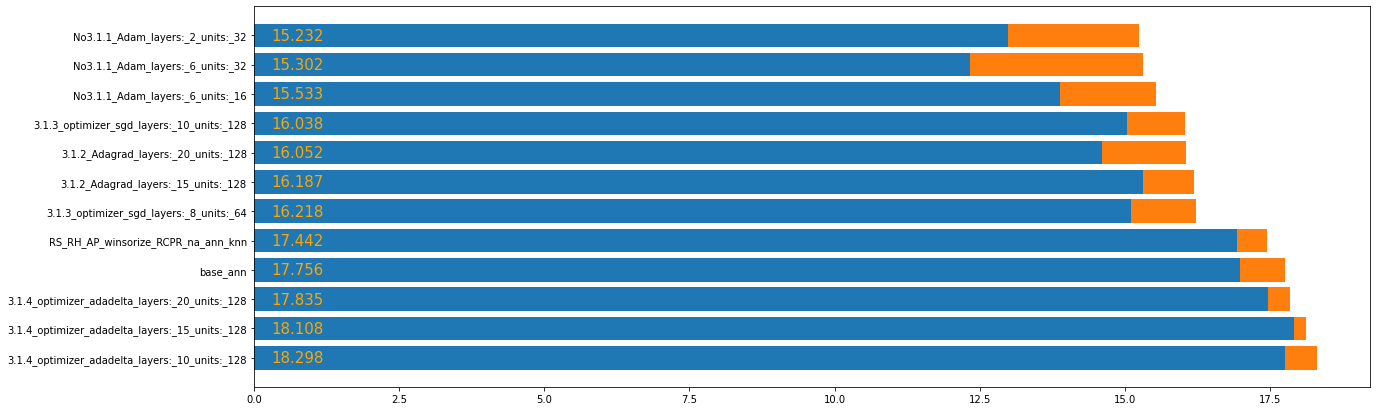

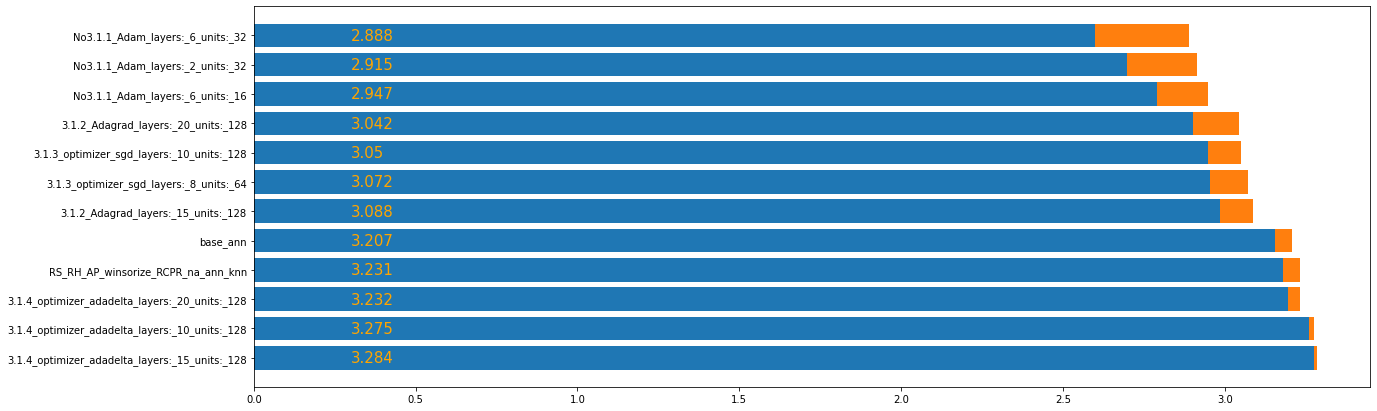

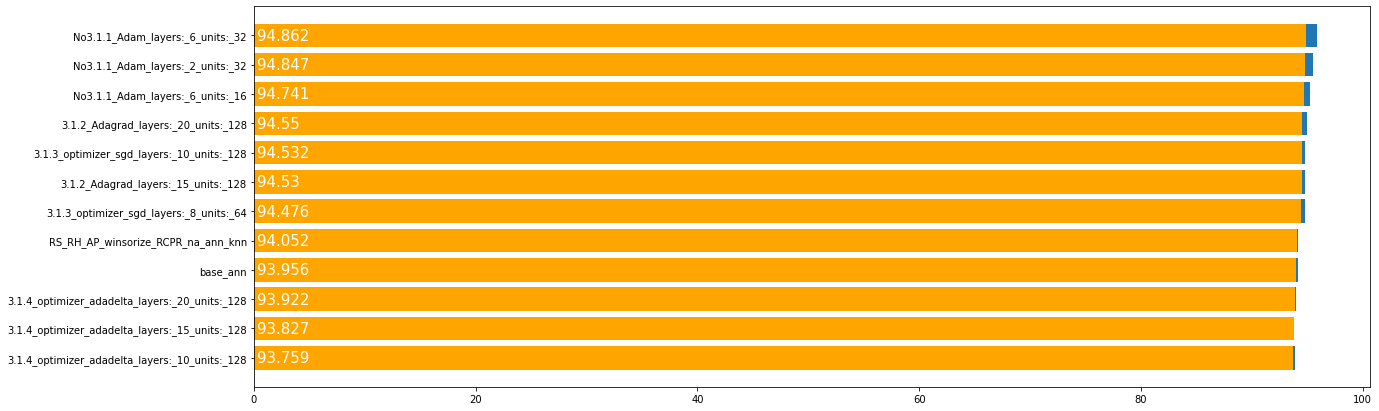

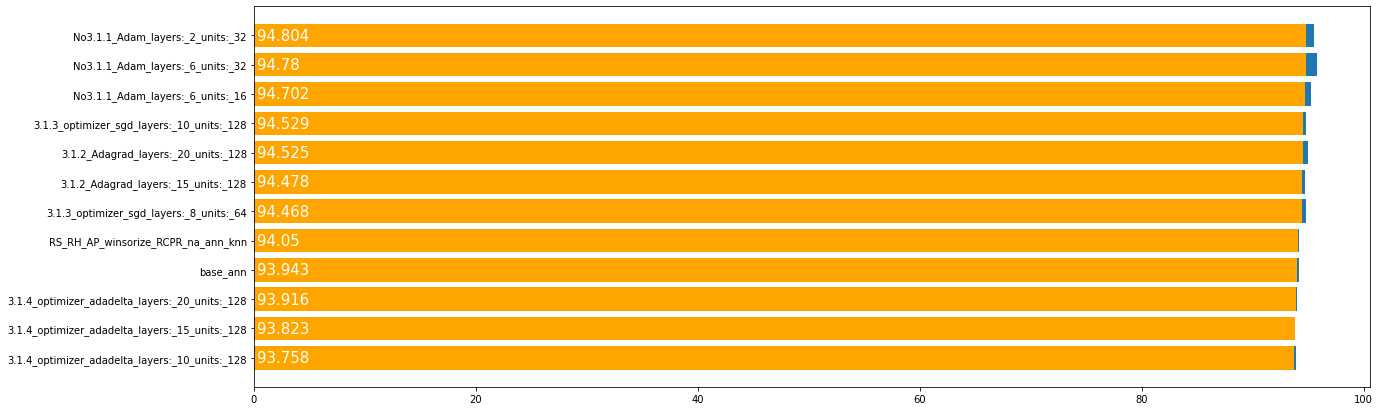

In [ ]:
update_results(True)
show_results()

As there was problem in GitHub (msg: unable to render rich display) file was splitted and the rest of optimizers with conclusion can be found in 4_2_4_PipelineDataPreprocessing_DL-ANN_Project_CPP_SGD_RMSProp_Results